# Healthcare Capacity Changes, a Global and Local Analysis
_A CS4132 Data Analytics project by Mendoza, Kieran Majel (M20404)_

## Table of Contents
1. [Motivation and Background](#motivation)
- [Summary of Research Questions and Results](#summary)
- [Datasets](#data)
- [Methodology](#method)
    - [Answering Question 1: What are the General Trends in Singapore's Healthcare Capacity over the Years?](#q1)
    - [Answering Question 2: How do the Healthcare Systems of the World Compare with each other over the Years?](#q2)
- [Results](#results)
    - [Results for Question 1](#rq1)
    - [Results for Question 2](#rq2)
- [Testing and Verification of Results](#verify)
- [Conclusion and Recommendations](#conc)
    - [In the Singaporean context](#cq1)
    - [In the global context](#cq2)
- [References](#ref)

<a id='motivation'></a>
## Motivation and Background

Since its independence in 1965, Singapore has undergone major changes, its population and healthcare structure being no exception. While Singapore’s healthcare system has been touted as one of the highest quality in the world, it may be another matter when looking at it from a capacity standpoint. Has the healthcare system been coping? Or is it struggling behind the scenes due to insufficient capacity? 

Extending outwards from Singapore, how much has the healthcare systems around the world expanded over the years? How do the healthcare systems of other countries compare and in what areas can Singapore learn from other countries?

This project aims to discover trends in healthcare capacity, on the national (Singapore) and the global level. The following are the research questions:

**1. What are the general trends in Singapore's healthcare capacity over the years?**

**2. How do the healthcare systems of the world compare with each other, and what are the general trends?**

Extending from this, we will also compare the healthcare capacity of other countries over the years.

From graphical representations produced in the data analysis, we will also come up with some recommendations to improve Singapore's healthcare system moving forward.

<a id='summary'></a>
## Summary of Research Questions and Results
**1. What are the general trends in Singapore's healthcare capacity over the years?**

Across the acute, psychiatric and community hospital sectors, we found that from 2006 to about 2012, the beds to population ratio remained fairly constant, but since then, the ratio has been consistently increasing.

Acute and psychiatric hospital admissions per bed has been increasing steadily, but the community hospital admissions per bed fluctuates greatly. Admissions seems to be lower on January and February but higher on March across these sectors.

Singapore will have an increase in elderly population in the future, with a second and smaller wave coming in about 20 years. The female population is also relatively increasing steadily.

**2. How do the healthcare systems of the world compare with each other over the years, and what are the general trends?**

Overall, the better performers are Austria, France, Germany, Japan and Switzerland. The worst-performing countries are Indonesia, Mexico and Brazil.

Hospital beds per 1000 population has been steadily decreasing in general. Notable exceptions include Korea, Turkey, China and India. The best-performing countries here are Sweden, Japan and Russia, and the worst-performing countries are India, Costa Rica and Mexico.

Healthcare spending has been steadily increasing worldwide but lately has been plateuing. India is an exception to the trend. Countries with the highest healthcare spending include the United States and France, and countries with the lowest healthcare spending are India and Turkey.

Number of doctors per 1000 population has generally been increasing, excluding Russia and Israel. Switzerland, Sweden and Russia perform well in this metric, with Indonesia and South Africa at the bottom of the scale.

**Skip to [results](#results)**

<a id='data'></a>
## Datasets

The following are the sources of my datasets:
1. Hospital Admissions in Singapore. It highlights the admissions of patients in Singapore across government hospitals, divided per sector over the years, per gender and age group.
https://data.gov.sg/dataset/hospital-admissions-and-public-sector-outpatient-attendances-annual?view_id=9d2923d9-4be1-4209-83cc-412e7f3d1f19&resource_id=ba3c89a7-cfc2-4c87-afe3-b688b0f0ad75
2. Number of beds in medical facilities in Singapore. It divides the number of hospital beds in Singapore since 2006 per sector per type of hospital.
https://data.gov.sg/dataset/health-facilities 
4. Singapore’s population over the years. Has data from 1950 on the population size, categorized by age, gender and type (resident, foreigner population) etc.
https://www.singstat.gov.sg/find-data/search-by-theme/population/population-and-population-structure/latest-data 
5. Global data on health spending by country. Includes several metrics like the spending by the population and the government and the percent of gdp used.
https://data.oecd.org/healthres/health-spending.htm
6. Global data on the hospital beds by country. Includes the division by sector.
https://data.oecd.org/healtheqt/hospital-beds.htm
7. Global data on the number of doctors by country per 1000 resident population. 
https://data.oecd.org/healthres/doctors.htm

In [1]:
#getting the necessary imports
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import requests
from scipy import interpolate,stats
from pywaffle import Waffle
import datetime

#getting the datasets
facilities = pd.read_excel('health-facilities677f70a63f3f4803b8d9294164dab3e9.xlsx')
beds = pd.read_excel('beds-in-inpatient-facilities-and-places-in-non-residential-long-term-care-facilities995485fa02ef40e294542e80f0977bc8.xlsx')
population = pd.read_excel('population.xlsx',sheet_name=[1,2,3,4])
admissions = pd.read_excel('admissions.xlsx',sheet_name=[1,2,3,4])
expenditures = pd.read_csv('household-healthcare-expenditure.csv')
global_beds = pd.read_csv('global_beds.csv')
global_doctors = pd.read_csv('global_doctors.csv')
global_spendings = pd.read_csv('global_healthcare_spendings.csv')

<a id='method'></a>
## Methodology
We describe the steps of our data analysis, first by cleaning the datasets and wrangling the data, then manipulating the data and finally plotting relevant graphs to visualise the results. 

<a id='q1'></a>
### Answering Question 1: What are the General Trends in Singapore's Healthcare Capacity over the Years?

Skip to [results for Question 1](#rq1)

This question aims to determine the trends in Singapore's 'effective' healthcare capacity over the years. We aim to use two metrics: the first being the **beds per capita**, and the second being the **hospital admissions per bed per sector**. 

Additionally, the population dynamics of Singapore will also be analyzed to create the appropriate recommendations for the government in the future.

**Datasets to be used are:**

[1] Hospital admissions in Singapore

[2] Number of beds in medical facilities in Singapore

[3] Singapore's population data

**Cleaning the datasets**

The following is meant to clean the datasets from the relevant files; the sheets in the excel files are of similar formatting and can therefore be passed to a function for cleaning, reusing the code.

We define certain functions (below) becuase these excel sheets use a similar template and can therefore be cleaned in a similar way.

In [2]:
##clean first sheet of admissions
def clean_admissions(df): #converts sheets from the admissions dataset to a dataframe.
    result = df.dropna(axis=0).reset_index(drop=True)
    result = result.apply(remove_comma,axis='columns').dropna(axis=1).reset_index(drop=True).T
    result.columns = result.iloc[0].tolist()
    result = result.reset_index(drop=True).drop([0]).reset_index(drop=True)
    result = result.replace('na',np.nan)
    result = result.replace('-',np.nan)
    return result

def clean_population(population_df): #converts sheets from the population dataset to a dataframe.
    temp = population_df.copy().T
    temp = temp.dropna(axis=1).reset_index(drop=True)
    temp.columns = temp.iloc[0].tolist()
    temp = temp.drop([0]).reset_index(drop=True)
    temp = temp.apply(remove_comma,axis='columns').replace('na',np.nan)
    return temp

def remove_comma(row): #helps in the conversion of data points to integers.
    row = row.astype(str)
    row = row.str.replace(",","")
    return row


We now load the datasets...

In [3]:
admissions_hospital = clean_admissions(admissions[1])
admissions_hospital.head()

Variables Public Sector Hospital Admissions         Alexandra Hospital  \
0  1987 Jan                             18822                       2345   
1  1987 Feb                             19074                       2188   
2  1987 Mar                             22173                       2641   
3  1987 Apr                             19797                       2348   
4  1987 May                             19602                       2357   

          Changi General Hospital         Khoo Teck Puat Hospital  \
0                             NaN                             NaN   
1                             NaN                             NaN   
2                             NaN                             NaN   
3                             NaN                             NaN   
4                             NaN                             NaN   

          National University Hospital         Ng Teng Fong General Hospital  \
0                                 1864                                   NaN   
1                                 1862                                   NaN   
2                                 2584                                   NaN   
3                                 2202                                   NaN   
4                                 2032                                   NaN   

          Sengkang General Hospital         Singapore General Hospital  \
0                               NaN                               5224   
1                               NaN                               5490   
2                               NaN                               6447   
3                               NaN                               5761   
4                               NaN                               5754   

          Tan Tock Seng Hospital         Communicable Disease Centre  \
0                           3937                                 NaN   
1                           4061                                 NaN   
2                           4128                                 NaN   
3                           3804                                 NaN   
4                           3629                                 NaN   

          National Centre For Infectious Diseases  \
0                                             NaN   
1                                             NaN   
2                                             NaN   
3                                             NaN   
4                                             NaN   

          Institute Of Mental Health / Woodbridge Hospital  \
0                                                493         
1                                                480         
2                                                518         
3                                                498         
4                                                469         

          Kandang Kerbau Women's & Children's Hospital  \
0                                               2412     
1                                               2420     
2                                               2892     
3                                               2686     
4                                               2739     

          National Heart Centre  
0                           NaN  
1                           NaN  
2                           NaN  
3                           NaN  
4                           NaN

In [4]:
admissions_monthly = clean_admissions(admissions[2])
admissions_monthly.head()

Variables Acute Hospitals Admissions         Public         Non-public  \
0  1987 Jan                        NaN            NaN                NaN   
1  1987 Feb                        NaN            NaN                NaN   
2  1987 Mar                        NaN            NaN                NaN   
3  1987 Apr                        NaN            NaN                NaN   
4  1987 May                        NaN            NaN                NaN   

  Psychiatric Hospitals Admissions         Public         Non-public  \
0                              NaN            NaN                NaN   
1                              NaN            NaN                NaN   
2                              NaN            NaN                NaN   
3                              NaN            NaN                NaN   
4                              NaN            NaN                NaN   

  Community Hospitals Admissions         Public         Non-public  \
0                            NaN            NaN                NaN   
1                            NaN            NaN                NaN   
2                            NaN            NaN                NaN   
3                            NaN            NaN                NaN   
4                            NaN            NaN                NaN   

  Specialist Outpatient Clinics Accident & Emergency Departments Polyclinics  \
0                         98721                            37771      240542   
1                        105174                            34188      254215   
2                        114172                            36113      262136   
3                        114022                            34127      245888   
4                        101491                            35922      219142   

  Dental Clinics  
0         103784  
1         122616  
2         107999  
3         110739  
4          84535

In [5]:
admissions_sector = clean_admissions(admissions[3])
admissions_sector.head()

Variables Acute Hospitals Admissions         Public         Non-public  \
0      1984                        NaN            NaN                NaN   
1      1985                        NaN            NaN                NaN   
2      1986                        NaN            NaN                NaN   
3      1987                        NaN            NaN                NaN   
4      1988                        NaN            NaN                NaN   

  Psychiatric Hospitals Admissions         Public         Non-public  \
0                              NaN            NaN                NaN   
1                              NaN            NaN                NaN   
2                              NaN            NaN                NaN   
3                              NaN            NaN                NaN   
4                              NaN            NaN                NaN   

  Community Hospitals Admissions         Public         Non-public  \
0                            NaN            NaN                NaN   
1                            NaN            NaN                NaN   
2                            NaN            NaN                NaN   
3                            NaN            NaN                NaN   
4                            NaN            NaN                NaN   

  Specialist Outpatient Clinics Accident & Emergency Departments Polyclinics  \
0                       1222817                           469522     3213404   
1                       1246343                           438308     3093967   
2                       1311863                           378145     3110000   
3                       1339712                           436660     2970997   
4                       1386350                           485762     2964035   

  Dental Clinics Day Surgeries  
0        1133267         14909  
1        1164031         15789  
2        1165610         18677  
3        1194752         20453  
4        1174672         22346

In [6]:
admissions_demographics = clean_admissions(admissions[4])
admissions_demographics.Variables = admissions_demographics.Variables.astype(float).astype(int)
admissions_demographics.head()

Variables Acute Hospitals - Male         0 - 14 Years Old  \
0       2006                   90.2                     92.5   
1       2007                     91                       95   
2       2008                   90.6                     99.2   
3       2009                   90.2                    100.1   
4       2010                   93.2                    104.3   

          15 - 64 Years Old         65 Years Old & Above  \
0                      64.0                        337.9   
1                      63.9                        340.4   
2                      62.6                        333.2   
3                      62.7                          323   
4                      63.8                        339.6   

  Acute Hospitals - Female         0 - 14 Years Old         15 - 64 Years Old  \
0                     98.3                     81.4                      77.4   
1                     99.4                     83.2                      77.3   
2                     98.1                     86.6                        75   
3                     96.4                     84.9                      73.5   
4                     98.3                       88                      74.2   

          65 Years Old & Above Psychiatric Hospitals - Male  ...  \
0                        295.7                          2.5  ...   
1                        299.8                          2.5  ...   
2                        294.8                          2.6  ...   
3                        287.7                          2.7  ...   
4                        295.3                          2.8  ...   

          15 - 64 Years Old         65 Years Old & Above  \
0                       2.0                          2.5   
1                       1.9                          2.1   
2                       2.1                          1.9   
3                       1.9                            2   
4                         2                          1.8   

  Community Hospitals - Male         0 - 14 Years Old  \
0                        1.2                      0.0   
1                        1.3                      NaN   
2                        1.4                      0.1   
3                        1.5                      NaN   
4                        1.7                      NaN   

          15 - 64 Years Old         65 Years Old & Above  \
0                       0.5                         12.2   
1                       0.5                         12.8   
2                       0.5                         13.5   
3                       0.6                         13.6   
4                       0.7                         14.9   

  Community Hospitals - Female         0 - 14 Years Old  \
0                          1.6                      0.0   
1                          1.6                      NaN   
2                          1.9                      NaN   
3                          1.9                      NaN   
4                            2                      NaN   

          15 - 64 Years Old         65 Years Old & Above  
0                       0.4                         14.1  
1                       0.4                         14.4  
2                       0.4                         16.4  
3                       0.4                         16.4  
4                       0.4                         16.9  

[5 rows x 25 columns]

In [7]:
#clean facilities
facilities = facilities.drop(['Unnamed: 0','HEALTH FACILITIES','Unnamed: 3','Unnamed: 4','Unnamed: 5'],axis=1)
facilities.columns = facilities.iloc[1].astype(str).tolist()
facilities = facilities.rename(columns={'nan':'Hospital'})
facilities = facilities.dropna(subset=['Hospital'],axis=0)[1:22].reset_index().drop(['index'],axis=1).replace('-',np.nan)
facilities.head()

Hospital  2006  2007  2008  2009  2010  2011  2012  2013  \
0       Acute Hospitals1  14.0  14.0  14.0  14.0  15.0  15.0  17.0  17.0   
1                 Public   7.0   7.0   7.0   7.0   8.0   8.0   8.0   8.0   
2         Not-for-Profit   1.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   
3                Private   6.0   6.0   6.0   6.0   6.0   6.0   8.0   8.0   
4  Psychiatric Hospitals   2.0   1.0   1.0   1.0   1.0   1.0   1.0   1.0   

   2014  2015  2016  2017  2018  2019  
0  18.0  19.0  19.0  18.0  19.0  19.0  
1   8.0   9.0   9.0   9.0  10.0  10.0  
2   1.0   1.0   1.0   1.0   1.0   1.0  
3   9.0   9.0   9.0   8.0   8.0   8.0  
4   1.0   1.0   1.0   1.0   1.0   1.0

In [8]:
#clean beds
beds = beds.drop(['Unnamed: 0','BEDS 1 IN INPATIENT FACILITIES','Unnamed: 3','Unnamed: 4','Unnamed: 5'],axis=1)
beds.columns = beds.iloc[1].astype(str).tolist()
beds = beds.rename(columns={'nan':'Hospital'})
beds = beds.dropna(subset=['Hospital'],axis=0)[1:22].reset_index(drop=True).replace('-',np.nan).T
beds.head()

0       1               2        3   \
Hospital  Acute Hospitals 2  Public  Not-for-Profit  Private   
2006                   8187    6256             303     1628   
2007                   8235    6304             303     1628   
2008                   8190    6255             303     1632   
2009                   8289    6416             303     1570   

                             4       5               6        7   \
Hospital  Psychiatric Hospitals  Public  Not-for-Profit  Private   
2006                       2113    2064             NaN       49   
2007                       2064    2064             NaN      NaN   
2008                       2064    2064             NaN      NaN   
2009                       2040    2040             NaN      NaN   

                           8         9   ...         11  \
Hospital  Community Hospitals  Public 3  ...  Private 5   
2006                      771       NaN  ...         58   
2007                      749       NaN  ...         58   
2008                      872       NaN  ...         58   
2009                      877       NaN  ...         58   

                                             12                       13  \
Hospital  Residential Long-Term Care Facilities  (by services offered) 6   
2006                                        NaN                      NaN   
2007                                        NaN                      NaN   
2008                                        NaN                      NaN   
2009                                        NaN                      NaN   

                       14      15                16       17  \
Hospital  Nursing Homes 7  Public  Not-for-Profit 4  Private   
2006                 9456     NaN              6174     3282   
2007                 9626     NaN              6122     3504   
2008                 9806     NaN              6149     3657   
2009                 9442     NaN              6262     3180   

                          18      19                20  
Hospital  Inpatient Hospices  Public  Not-for-Profit 4  
2006                     129     NaN               129  
2007                     129     NaN               129  
2008                     129     NaN               129  
2009                     129     NaN               129  

[5 rows x 21 columns]

In [9]:
population_overall = clean_population(population[1])
population_overall.head()

Variables Total Population(Number) Resident Population(Number)  \
0      1950                  1022100                         NaN   
1      1951                  1068100                         NaN   
2      1952                  1127000                         NaN   
3      1953                  1191800                         NaN   
4      1954                  1248200                         NaN   

  Singapore Citizen Population(Number) Permanent Resident Population(Number)  \
0                                  NaN                                   NaN   
1                                  NaN                                   NaN   
2                                  NaN                                   NaN   
3                                  NaN                                   NaN   
4                                  NaN                                   NaN   

  Non-resident Population(Number) Total Population Growth(Per Cent)  \
0                             NaN                               4.4   
1                             NaN                               4.5   
2                             NaN                               5.5   
3                             NaN                               5.7   
4                             NaN                               4.7   

  Resident Population Growth(Per Cent)  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  Population Density(Total Population Per Square Kilometre)  \
0                                                NaN          
1                                                NaN          
2                                                NaN          
3                                                NaN          
4                                                NaN          

  Sex Ratio(Males Per Thousand Females)  ...  \
0                                  1173  ...   
1                                  1159  ...   
2                                  1153  ...   
3                                  1149  ...   
4                                  1138  ...   

  Old-age Support Ratio: Citizens Aged 15-64 Years Per Citizen Aged 65 Years & Over(Per Citizen Aged 65 Years & Over)  \
0                                                NaN                                                                    
1                                                NaN                                                                    
2                                                NaN                                                                    
3                                                NaN                                                                    
4                                                NaN                                                                    

  Old-age Support Ratio: Citizens Aged 20-64 Years Per Citizen Aged 65 Years & Over(Per Citizen Aged 65 Years & Over)  \
0                                                NaN                                                                    
1                                                NaN                                                                    
2                                                NaN                                                                    
3                                                NaN                                                                    
4                                                NaN                                                                    

  Dependency Ratio: Citizens Aged Under 15 Years And 65 Years & Over Per Hundred Citizens Aged 15-64 Years(Per Hundred Citizens Aged 15-64 Years)  \
0                                                NaN                                                                                                
1           

In [10]:
population_demographic = clean_population(population[3])
population_demographic.head()

Variables Total Citizen         0  -  4 Years         5  -  9 Years  \
0      1970       1874778                226454                267122   
1      1980       2194280                183210                213775   
2      1990       2623736                219067                198516   
3      1991       2664625                228811                198547   
4      1992       2702430                237499                197004   

          10 - 14 Years         15 - 19 Years         20 - 24 Years  \
0                273014                227001                175775   
1                224112                264927                264370   
2                191808                217727                230311   
3                193588                212689                221998   
4                194030                208069                218685   

          25 - 29 Years         30 - 34 Years         35 - 39 Years  ...  \
0                102974                112188                 99402  ...   
1                222280                183267                113943  ...   
2                275477                284011                243492  ...   
3                271145                287075                254619  ...   
4                264285                286176                265506  ...   

          70 - 74 Years         75 - 79 Years         80 - 84 Years  \
0                   153                    85                   NaN   
1                   166                   140                    82   
2                   301                   210                   108   
3                   307                   218                   112   
4                   334                   211                   126   

          85 - 89 Years         65 Years & Over         70 Years & Over  \
0                   NaN                     557                     332   
1                   NaN                     693                     430   
2                   NaN                    1115                     697   
3                   NaN                    1170                     727   
4                   NaN                    1223                     767   

          75 Years & Over         80 Years & Over         85 Years & Over  \
0                     179                      94                     NaN   
1                     264                     124                      42   
2                     396                     186                      78   
3                     420                     203                      91   
4                     433                     222                      96   

          90 Years & Over  
0                     NaN  
1                     NaN  
2                     NaN  
3                     NaN  
4                     NaN  

[5 rows x 376 columns]

**Using the first metric (beds per capita)...**

We take the year-on-year number of beds across the acute, psychiatric and community hospitals and then merge it with the resident population for those years. 

In [11]:
cols = ['Acute Hospitals','Psychiatric Hospitals','Community Hospitals']
total_beds=beds.iloc[:,[0,4,8]].copy()
total_beds.iloc[:,1:]= total_beds.iloc[:,1:]
total_beds.columns=cols
total_beds = total_beds.drop(['Hospital'])
total_beds['year'] = total_beds.index.astype(int)
total_beds[cols] = total_beds[cols].astype(int)

resident_population = population_overall.iloc[:,[0,2]].copy()
resident_population.rename(columns={'Variables':'year','Resident Population(Number)':'resident_population'},inplace=True)
resident_population['resident_population'] = resident_population['resident_population'].astype(float)
resident_population['year'] = resident_population.astype(float)

metric_1 = total_beds.merge(resident_population,how='outer',on='year').sort_values(by='year').reset_index(drop=True)
metric_1.tail()

Acute Hospitals  Psychiatric Hospitals  Community Hospitals  year  \
65           9844.0                 1950.0               1464.0  2015   
66          10318.0                 1950.0               1663.0  2016   
67          10340.0                 1950.0               1663.0  2017   
68          10826.0                 1950.0               1778.0  2018   
69          11321.0                 1950.0               1986.0  2019   

    resident_population  
65            3902690.0  
66            3933559.0  
67            3965796.0  
68            3994283.0  
69            4026209.0

**Line graph of number of beds per sector over time**

Mainly to show the unadjusted change in capacity over the years. We can see that the acute and community hospitals are increasing more than the psychiatric hospitals.

Text(0.5, 1.0, "Graph of Singapore's admissions per sector over the years")

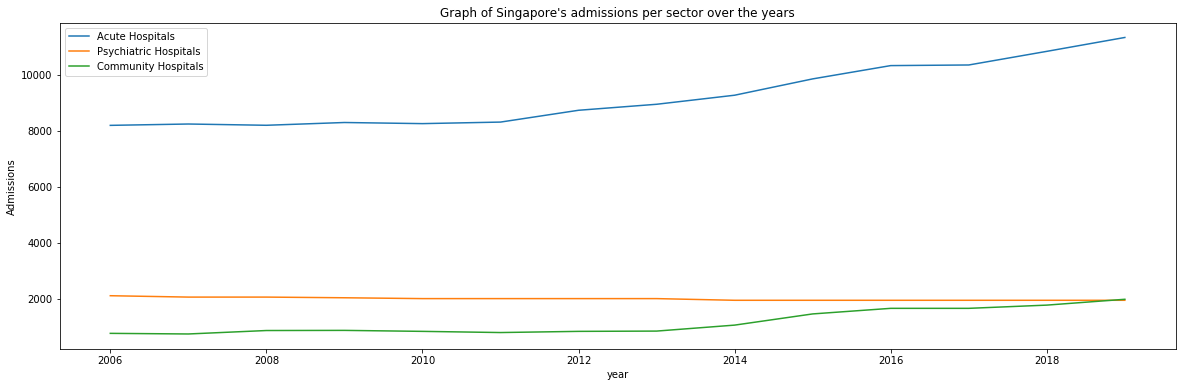

In [12]:
fig = plt.figure(figsize=(20,6))
ax0 = fig.add_subplot(1, 1, 1)
metric_1.plot(x='year',y='Acute Hospitals',ax=ax0)
metric_1.plot(x='year',y='Psychiatric Hospitals',ax=ax0)
metric_1.plot(x='year',y='Community Hospitals',ax=ax0)
plt.ylabel('Admissions')
plt.title('Graph of Singapore\'s admissions per sector over the years')

**Line graph of resident population growth over time**

We can see that the resident population is still increasing, but beginning to plateau. 

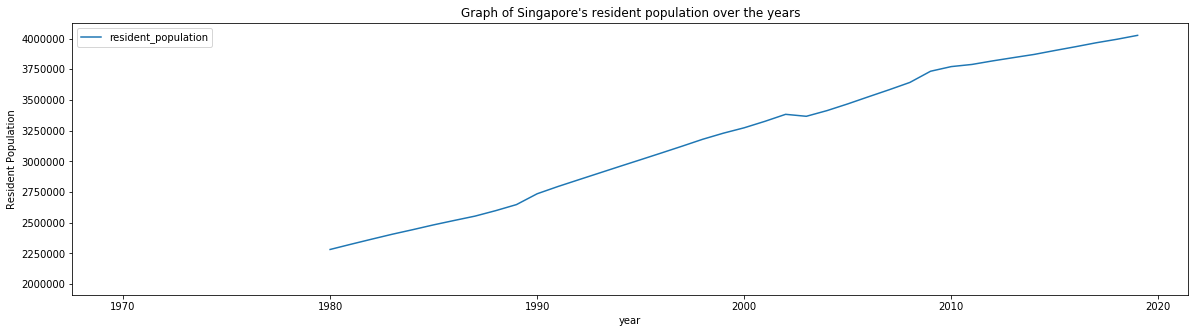

In [13]:
metric_1.plot(x='year',y='resident_population',figsize=(20,5))
plt.ylabel('Resident Population')
plt.title('Graph of Singapore\'s resident population over the years')
plt.show()

**Line graph of the beds per capita over time**

This is the produced result from finding the ratio. A function applies the ratio in a row-wise manner, and stores the result in a new column of the dataframe.

We found that the ratio is more or less steady approaching the year of 2012, then increases since then across acute and community hospitals. The psychiatric hospitals haven't been following the trend of the other two sectors, with it decreasing steadily.

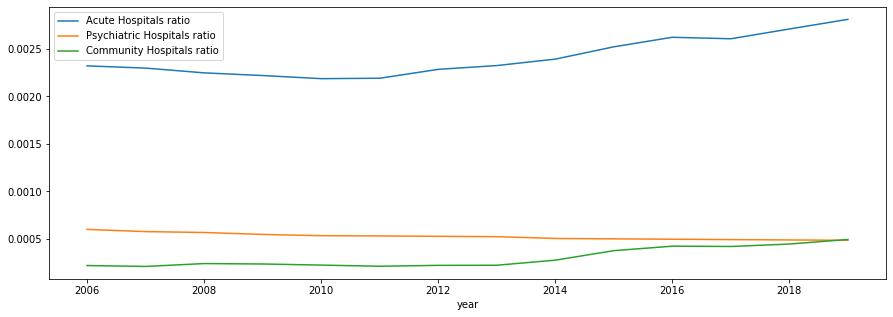

In [14]:
fig = plt.figure(figsize=(15,5))
res1 = fig.add_subplot(1, 1, 1)
def calc_score(row):
    for string in cols:
        row[string+' ratio'] = row[string] / row.resident_population
    return row

result = metric_1.apply(calc_score,axis='columns')
result.plot(x='year',y='Acute Hospitals ratio',ax=res1)
result.plot(x='year',y='Psychiatric Hospitals ratio',ax=res1)
result.plot(x='year',y='Community Hospitals ratio',ax=res1)

**Using the second metric, admissions per bed per sector...**

We take the data for the same three sectors and then convert the year and month to a datetime for easier plotting. 

In [15]:
admissions_limited = admissions_monthly.copy()
cols = admissions_limited.columns[[1,4,7,10,11,12,13]]
admissions_limited.Variables = pd.to_datetime(admissions_limited.Variables,format='%Y %b')
admissions_limited = admissions_limited.iloc[:,[0,1,4,7,10,11,12,13]].dropna()
admissions_limited[cols] = admissions_limited[cols].applymap(int)
admissions_limited['year'] = pd.DatetimeIndex(admissions_limited['Variables']).year
admissions_limited['month'] = pd.DatetimeIndex(admissions_limited['Variables']).month
admissions_limited.head()

Variables  Acute Hospitals Admissions  Psychiatric Hospitals Admissions  \
228 2006-01-01                       31709                               595   
229 2006-02-01                       30352                               528   
230 2006-03-01                       35127                               777   
231 2006-04-01                       32435                               654   
232 2006-05-01                       33524                               701   

     Community Hospitals Admissions  Specialist Outpatient Clinics  \
228                             446                         271747   
229                             373                         284331   
230                             525                         328468   
231                             497                         279846   
232                             494                         313965   

     Accident & Emergency Departments  Polyclinics  Dental Clinics  year  \
228                             56313       283681           80607  2006   
229                             51647       315017           98515  2006   
230                             55432       343239           86362  2006   
231                             53997       305709           72491  2006   
232                             59631       327812           63427  2006   

     month  
228      1  
229      2  
230      3  
231      4  
232      5

**Line graph of hospital admissions over time, by sector**

This is an unadjusted graph of the admissions across the healthcare sectors, including those that are not the three main sectors we are looking into.

We can see that there is large amounts of fluctuation throughout the graphs, but the graphs seem to spike at regular rates. We also notice that the deviation of the graphs from the trend seems to increase towards 2020.

Text(0.5, 1.0, 'Admissions per sector')

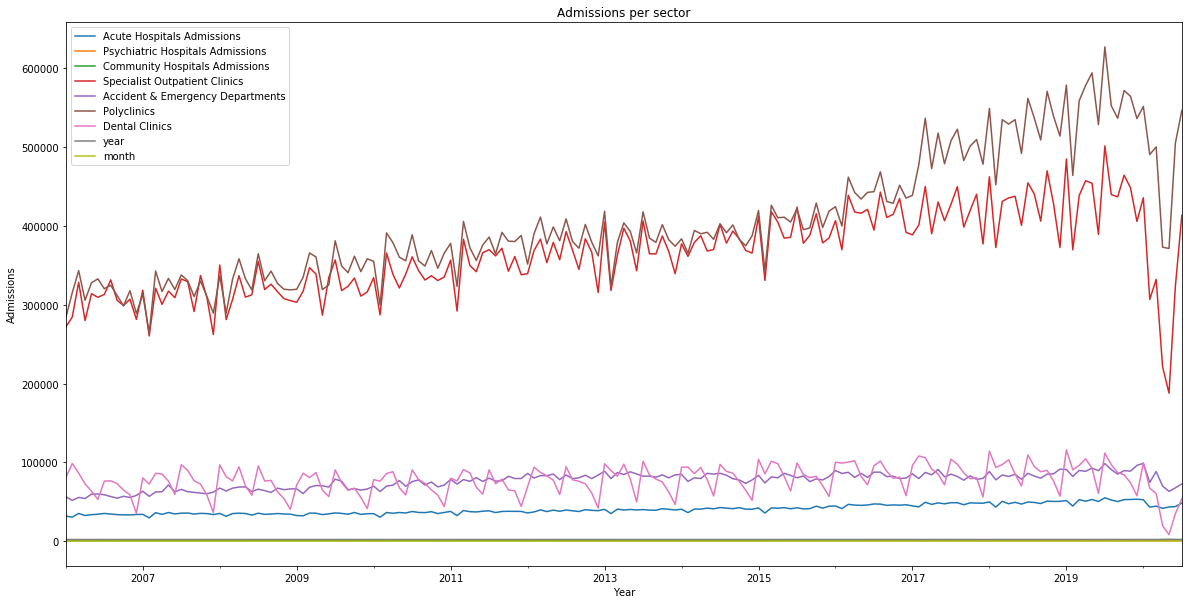

In [16]:
admissions_limited.plot(kind='line',x='Variables',figsize=(20,10))
plt.xlabel('Year')
plt.ylabel('Admissions')
plt.title('Admissions per sector')

**Line graph of admissions per bed over time, by sector**

We define a function that returns a row 3 new columns with the ratio of admissions per hospital bed. This updated dataframe will be used to plot a regression graph that shows the general trend of the changes in admissions per bed per sector.

We found that there is a moderately strong positive relationship between the acute hospital admissions per bed and the time, and weaker positive relationships between the psychiatric and community hospital admissions per bed and the time.

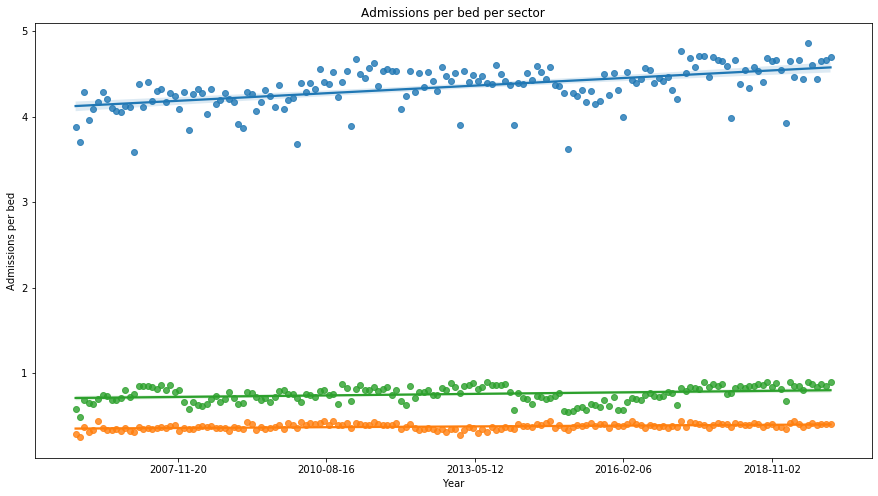

In [17]:
beds_yearly = total_beds.copy().reset_index(drop=True)
admissions_adj = admissions_limited.copy().reset_index(drop=True)
def divide_year_value(row):
    row['AH admissions / bed'] = row['Acute Hospitals Admissions'] / row['Acute Hospitals']
    row['PH admissions / bed'] = row['Psychiatric Hospitals Admissions'] / row['Psychiatric Hospitals']
    row['CH admissions / bed'] = row['Community Hospitals Admissions'] / row['Community Hospitals']
    return row
beds_yearly = beds_yearly.merge(admissions_adj,on='year').apply(divide_year_value,axis='columns')
admissions_bed_sector = beds_yearly[['AH admissions / bed','PH admissions / bed','CH admissions / bed','Variables']].copy()
admissions_bed_sector['Variables'] = admissions_bed_sector['Variables'].apply(lambda date: date.toordinal())
#admissions_bed_sector.plot(kind='line',x='Variables',figsize=(20,10))
plt.figure(figsize=(15,8))
ax = sns.regplot(x='Variables', y='AH admissions / bed', data=admissions_bed_sector)
sns.regplot(x='Variables', y='PH admissions / bed', data=admissions_bed_sector)
sns.regplot(x='Variables', y='CH admissions / bed', data=admissions_bed_sector)
plt.title('Admissions per bed per sector')
plt.ylabel('Admissions per bed')
plt.xlabel('Year')
new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)
plt.show()

In [18]:
pearson_coef, p_value = stats.pearsonr(admissions_bed_sector['Variables'], admissions_bed_sector['AH admissions / bed'])
pearson_coef, p_value

(0.5591425153921088, 3.3455952698430855e-15)

In [19]:
pearson_coef, p_value = stats.pearsonr(admissions_bed_sector['Variables'], admissions_bed_sector['PH admissions / bed'])
pearson_coef, p_value

(0.40584873134958643, 4.819170468511711e-08)

In [20]:
pearson_coef, p_value = stats.pearsonr(admissions_bed_sector['Variables'], admissions_bed_sector['CH admissions / bed'])
pearson_coef, p_value

(0.28411275587892937, 0.00018978631942660195)

**Boxplots of changes in admissions per bed year-on-year and month-on-month, by sector**
This section was made due to the observation that there seem to be regular spikes in the number of admissions. We therefore created boxplots for the admissions per bed by sector, showing the median admissions for every month.

Sure enough, we found that the admissions seem to be lower on January and February than normal, with higher admissions on March and September. 

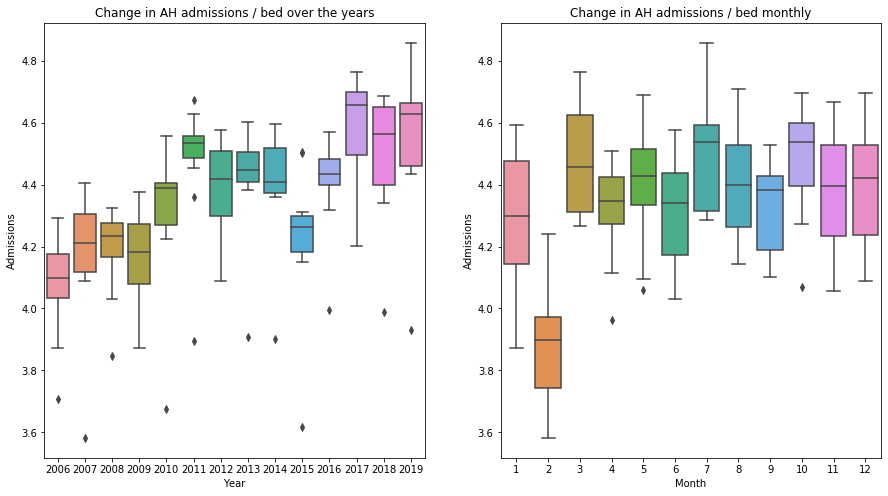

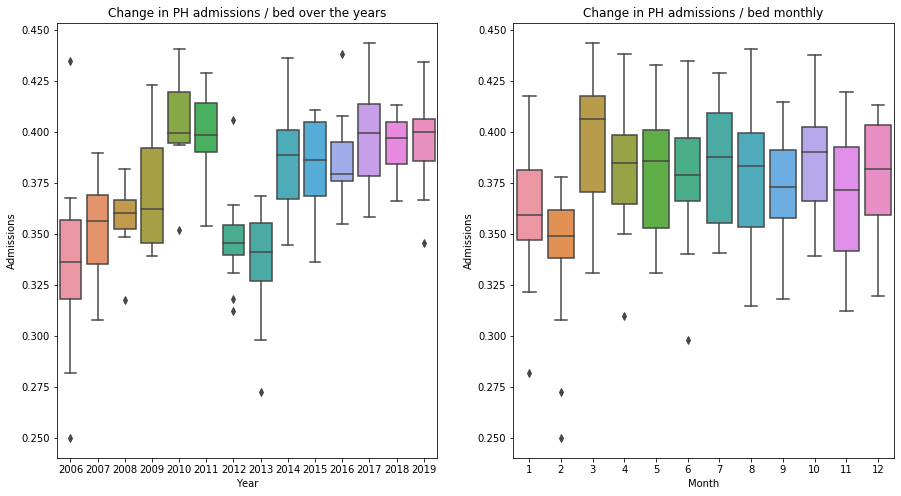

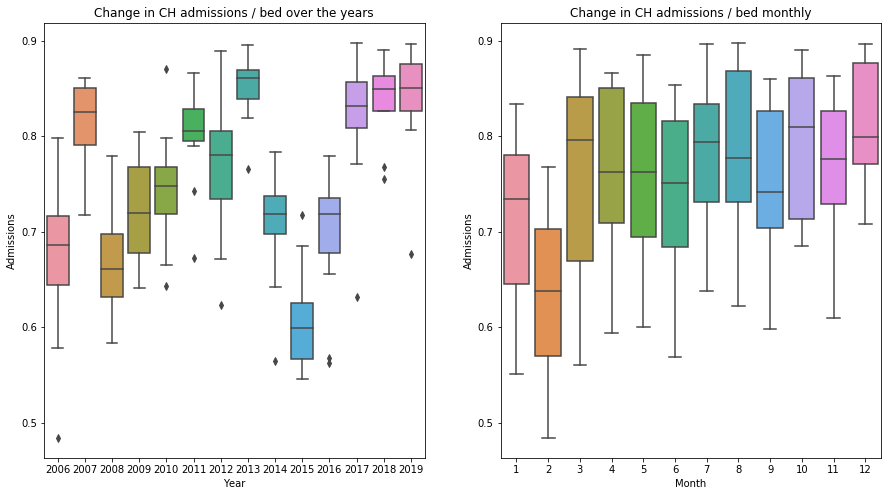

In [21]:
for string in beds_yearly[['AH admissions / bed','PH admissions / bed','CH admissions / bed']]:
    fig = plt.figure(figsize=(15,8))
    ax0 = fig.add_subplot(1, 2, 1)
    ax1 = fig.add_subplot(1, 2, 2) 
    sns.boxplot(y=beds_yearly[string],x=beds_yearly['year'],data=beds_yearly,ax=ax0)
    ax0.set_title('Change in ' + string + " over the years")
    ax0.set_ylabel('Admissions')
    ax0.set_xlabel('Year')
    sns.boxplot(y=beds_yearly[string],x=beds_yearly['month'],data=beds_yearly,ax=ax1)
    ax1.set_title('Change in ' + string + ' monthly')
    ax1.set_ylabel('Admissions')
    ax1.set_xlabel('Month')

**An analysis of Singapore's demographics over time...**

Looking into the future, we must be prepared for the changes in demographics and therefore tailor Singapore's healthcare systems to accommdate this change.

We will create a dataframe that will contain the overall population by age groups, and express it as a percentage of the resident population. Again, this can be done via a row-wise function that takes in the raw population and divide it by the resident population for that year.

In [22]:
population_dynamics = population_demographic.copy().astype(float)
population_dynamics.Variables = pd.to_datetime(population_dynamics.Variables,format='%Y')
unique = population_dynamics.columns.unique().tolist()
age_groups = [string for string in unique if 'Years' in string]
age_groups = population_dynamics[pd.Index(age_groups)]
age_groups.index = population_dynamics.Variables
age_groups = population_dynamics.iloc[:,:20]

def find_percent(row):
    row[2:] = row[2:] *100 / row['Total Citizen']
    return row
age_groups = age_groups.apply(find_percent,axis='columns').drop(['Total Citizen'],axis=1)
age_groups.head()

Variables          0  -  4 Years          5  -  9 Years  \
0 1970-01-01              12.078977              14.248194   
1 1980-01-01               8.349436               9.742376   
2 1990-01-01               8.349430               7.566158   
3 1991-01-01               8.586987               7.451217   
4 1992-01-01               8.788350               7.289884   

           10 - 14 Years          15 - 19 Years          20 - 24 Years  \
0              14.562471              12.108154               9.375777   
1              10.213464              12.073528              12.048143   
2               7.310492               8.298358               8.777979   
3               7.265112               7.981949               8.331304   
4               7.179834               7.699330               8.092161   

           25 - 29 Years          30 - 34 Years          35 - 39 Years  \
0               5.492597               5.984069               5.302068   
1              10.129974               8.352033               5.192728   
2              10.499418              10.824679               9.280354   
3              10.175728              10.773561               9.555528   
4               9.779532              10.589580               9.824713   

           40 - 44 Years          45 - 49 Years          50 - 54 Years  \
0               4.774059               3.869578               3.413738   
1               5.236068               4.446652               3.891709   
2               7.491531               4.598824               4.272953   
3               8.002252               4.541314               4.486560   
4               8.095566               5.135267               4.596012   

           55 - 59 Years          60 - 64 Years          65 - 69 Years  \
0               3.166242               2.380282               1.612351   
1               2.993784               2.530306               2.099641   
2               3.678648               3.043408               2.189435   
3               3.661791               3.089741               2.229432   
4               3.593951               3.101912               2.301854   

           70 - 74 Years          75 - 79 Years          80 - 84 Years  \
0               0.881918               0.459468                    NaN   
1               1.412400               0.781167               0.327397   
2               1.654473               1.186019               0.639127   
3               1.656293               1.173599               0.678407   
4               1.666167               1.168356               0.710213   

           85 - 89 Years  
0                    NaN  
1                    NaN  
2                    NaN  
3                    NaN  
4                    NaN

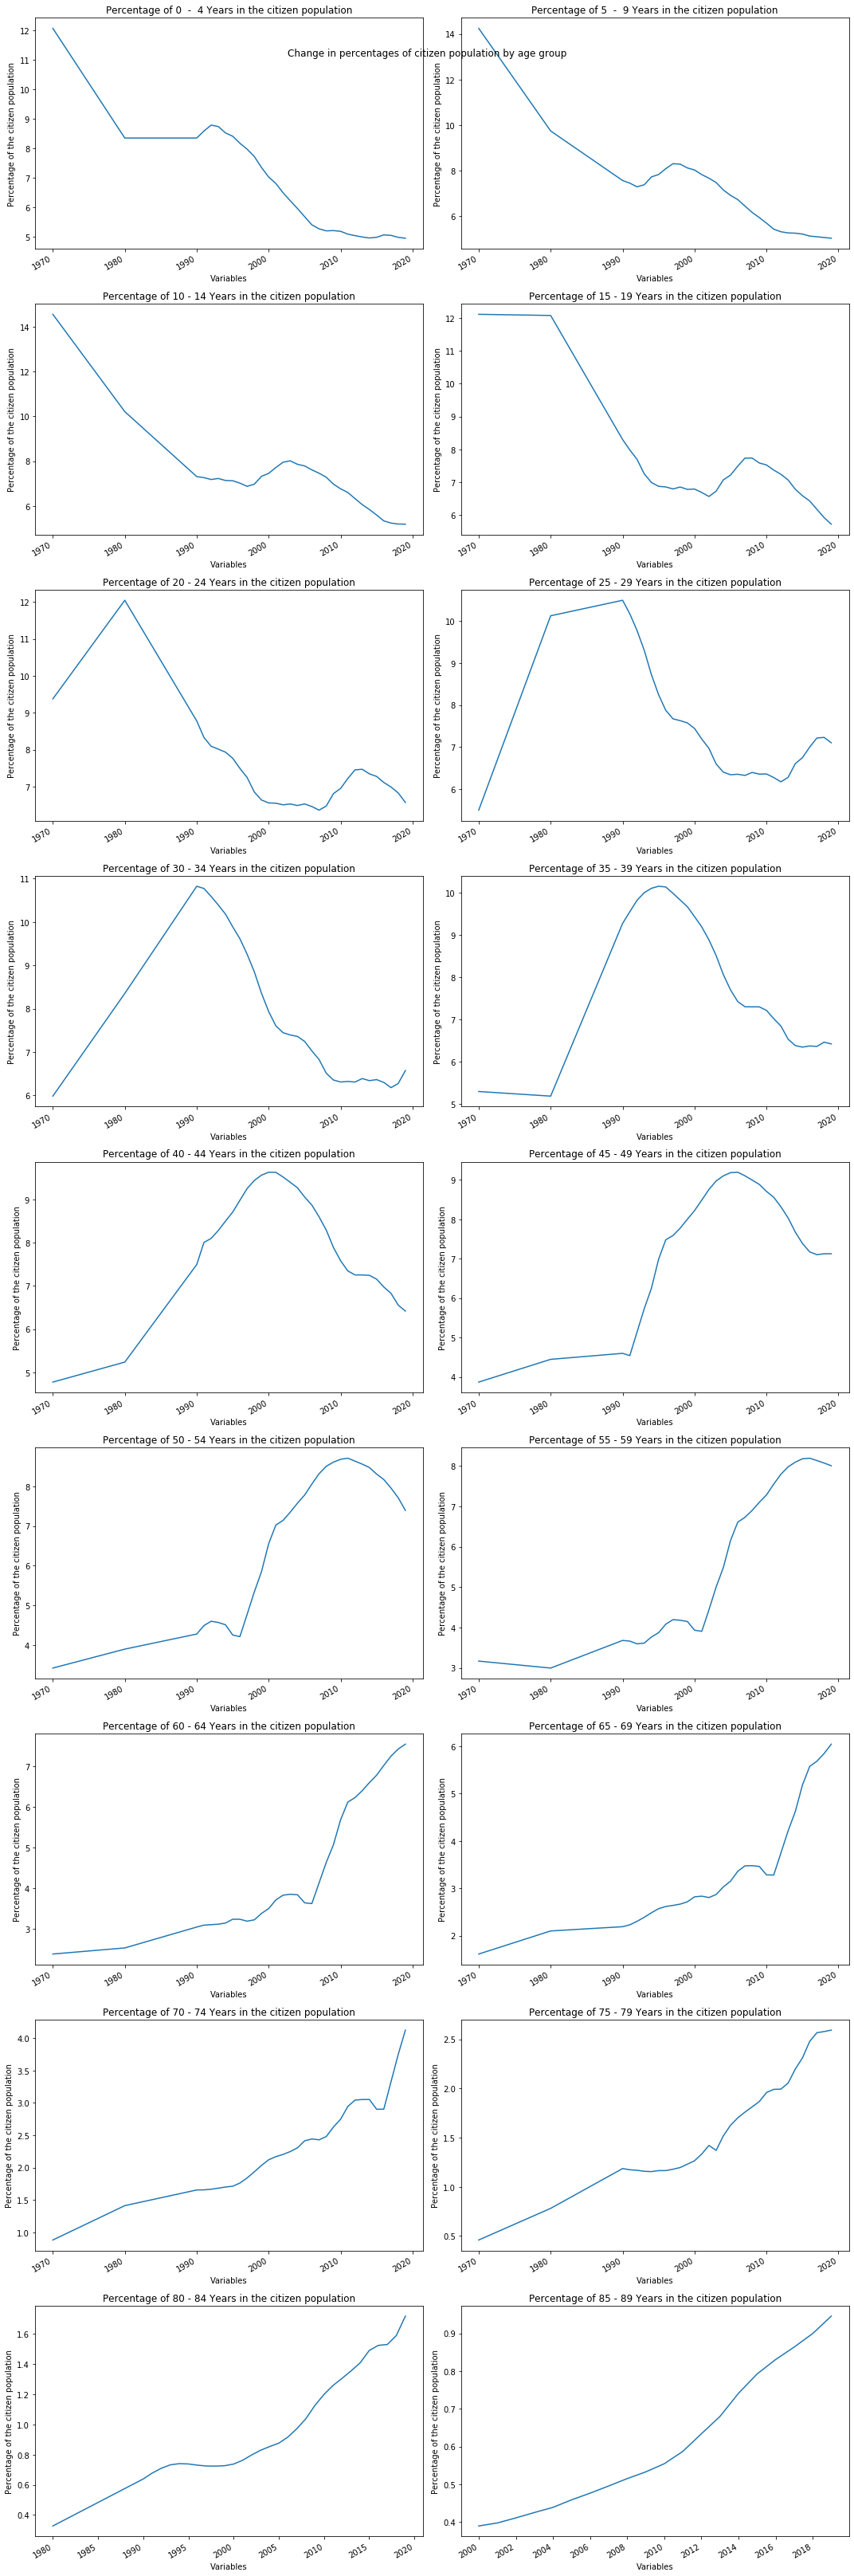

In [23]:
fig, axes = plt.subplots(nrows=9, ncols=2,  tight_layout=True)
groups = age_groups.iloc[:,1:]
groups.index = age_groups.Variables
i=0
for ax, c in zip(axes.ravel(), groups):
    groups.iloc[:,i].plot(kind='line', x='Variables', legend=None, ax=ax,figsize=(15,45))
    ax.set_title('Percentage of '+c.strip()+ ' in the citizen population')
    ax.set_ylabel('Percentage of the citizen population')
    i = i+1

fig.suptitle('Change in percentages of citizen population by age group')
plt.show()

In [24]:
genders = population_dynamics.loc[:,['Variables','Total Citizen','Total Male Citizens','Total Female Citizens']]
genders = genders.apply(find_percent,axis='columns').drop(['Total Citizen'],axis=1)
genders.head()

Variables  Total Male Citizens  Total Female Citizens
0 1970-01-01            51.353974              48.646026
1 1980-01-01            50.967014              49.032986
2 1990-01-01            50.641147              49.358853
3 1991-01-01            50.597213              49.402787
4 1992-01-01            50.531411              49.468552

[Text(0, 0, '1965-06-13'),
 Text(0, 0, '1972-04-17'),
 Text(0, 0, '1979-02-20'),
 Text(0, 0, '1985-12-25'),
 Text(0, 0, '1992-10-29'),
 Text(0, 0, '1999-09-03'),
 Text(0, 0, '2006-07-08'),
 Text(0, 0, '2013-05-12'),
 Text(0, 0, '2020-03-16'),
 Text(0, 0, '2027-01-19')]

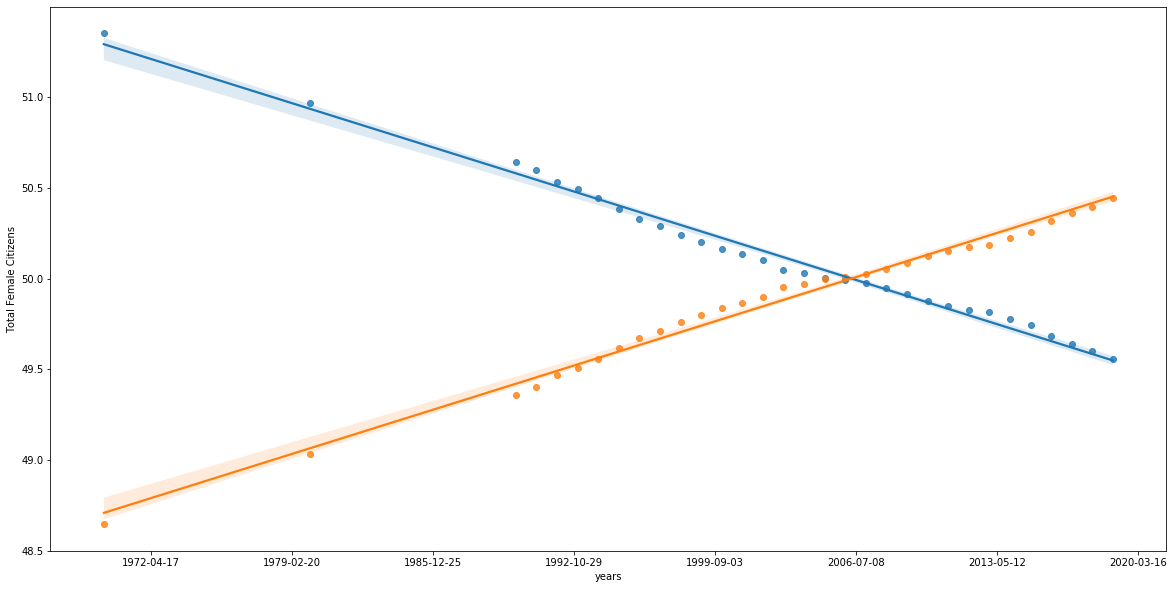

In [25]:
plt.figure(figsize=(20,10))
genders['Variables'] = genders['Variables'].apply(lambda date: date.toordinal())
ax = sns.regplot(x='Variables',y='Total Male Citizens',data=genders)
sns.regplot(x='Variables',y='Total Female Citizens',data=genders)
plt.xlabel('years')
new_labels = [datetime.date.fromordinal(int(item)) for item in ax.get_xticks()]
ax.set_xticklabels(new_labels)

In [26]:
pearson_coef, p_value = stats.pearsonr(genders['Variables'], genders['Total Male Citizens'])
pearson_coef, p_value

(-0.9948281033899585, 2.318468774357967e-31)

In [27]:
pearson_coef, p_value = stats.pearsonr(genders['Variables'], genders['Total Female Citizens'])
pearson_coef, p_value

(0.9948273004754346, 2.3238613558725387e-31)

<a id='q2'></a>
### Answering Question 2: How do the Healthcare Systems of the World Compare with each other over the Years?

Skip to [results for Question 2](#rq2)

There are multiple ways to determine the effectiveness of healthcare systems; spending, actual capacity and the number of doctors are the factors we will look into. 

We will first use these metrics independently, then combine them to get a better picture of the healthcare situation in these countries..

**Below are the datasets to be used:**

[5] Global data on health spending by country.

[6] Global data on the hospital beds by country.

[7] Global data on the number of doctors by country. 

Curiously, we found that the data does not need to be cleaned, though there are some columns that are not in the scope of this question (e.g frequency and flag codes), so we remove it anyway.

In [28]:
def remove_extra_columns(df):
    result = df.drop(['Flag Codes','FREQUENCY'],axis=1)
    return result

In [29]:
global_beds = remove_extra_columns(global_beds)
global_beds.head()

LOCATION    INDICATOR SUBJECT  MEASURE  TIME  Value
0      AUS  HOSPITALBED     TOT  1000HAB  1960   9.65
1      AUS  HOSPITALBED     TOT  1000HAB  1961   9.48
2      AUS  HOSPITALBED     TOT  1000HAB  1962   9.38
3      AUS  HOSPITALBED     TOT  1000HAB  1963   9.36
4      AUS  HOSPITALBED     TOT  1000HAB  1964   9.23

In [30]:
global_spendings = remove_extra_columns(global_spendings)
global_spendings.head()

LOCATION  INDICATOR SUBJECT MEASURE  TIME  Value
0      AUS  HEALTHEXP     TOT  PC_GDP  1971  4.547
1      AUS  HEALTHEXP     TOT  PC_GDP  1972  4.547
2      AUS  HEALTHEXP     TOT  PC_GDP  1973  4.511
3      AUS  HEALTHEXP     TOT  PC_GDP  1974  5.112
4      AUS  HEALTHEXP     TOT  PC_GDP  1975  5.760

In [31]:
global_doctors = remove_extra_columns(global_doctors)
global_doctors.head()

LOCATION   INDICATOR SUBJECT  MEASURE  TIME  Value
0      AUS  MEDICALDOC     TOT  1000HAB  1961   1.13
1      AUS  MEDICALDOC     TOT  1000HAB  1964   1.23
2      AUS  MEDICALDOC     TOT  1000HAB  1965   1.22
3      AUS  MEDICALDOC     TOT  1000HAB  1966   1.23
4      AUS  MEDICALDOC     TOT  1000HAB  1967   1.26

**We first investigate the trends in the number of hospital beds over time...**

We will plot four graphs: 
1. A boxplot of the changes in overall hospital beds per 1000 population over time, from a global standpoint.
2. A boxplot of the changes in hospital beds per 1000 population over time, by sector.
3. A boxplot of the hospital beds per 1000 population by country.
4. A line graph of the change in hospital beds per 1000 population over time.

We found that this figure has generally been decreasing over the years, with acute hospitals having greater beds per 1000 population than psychiatric ones. Japan and Sweden do well here.

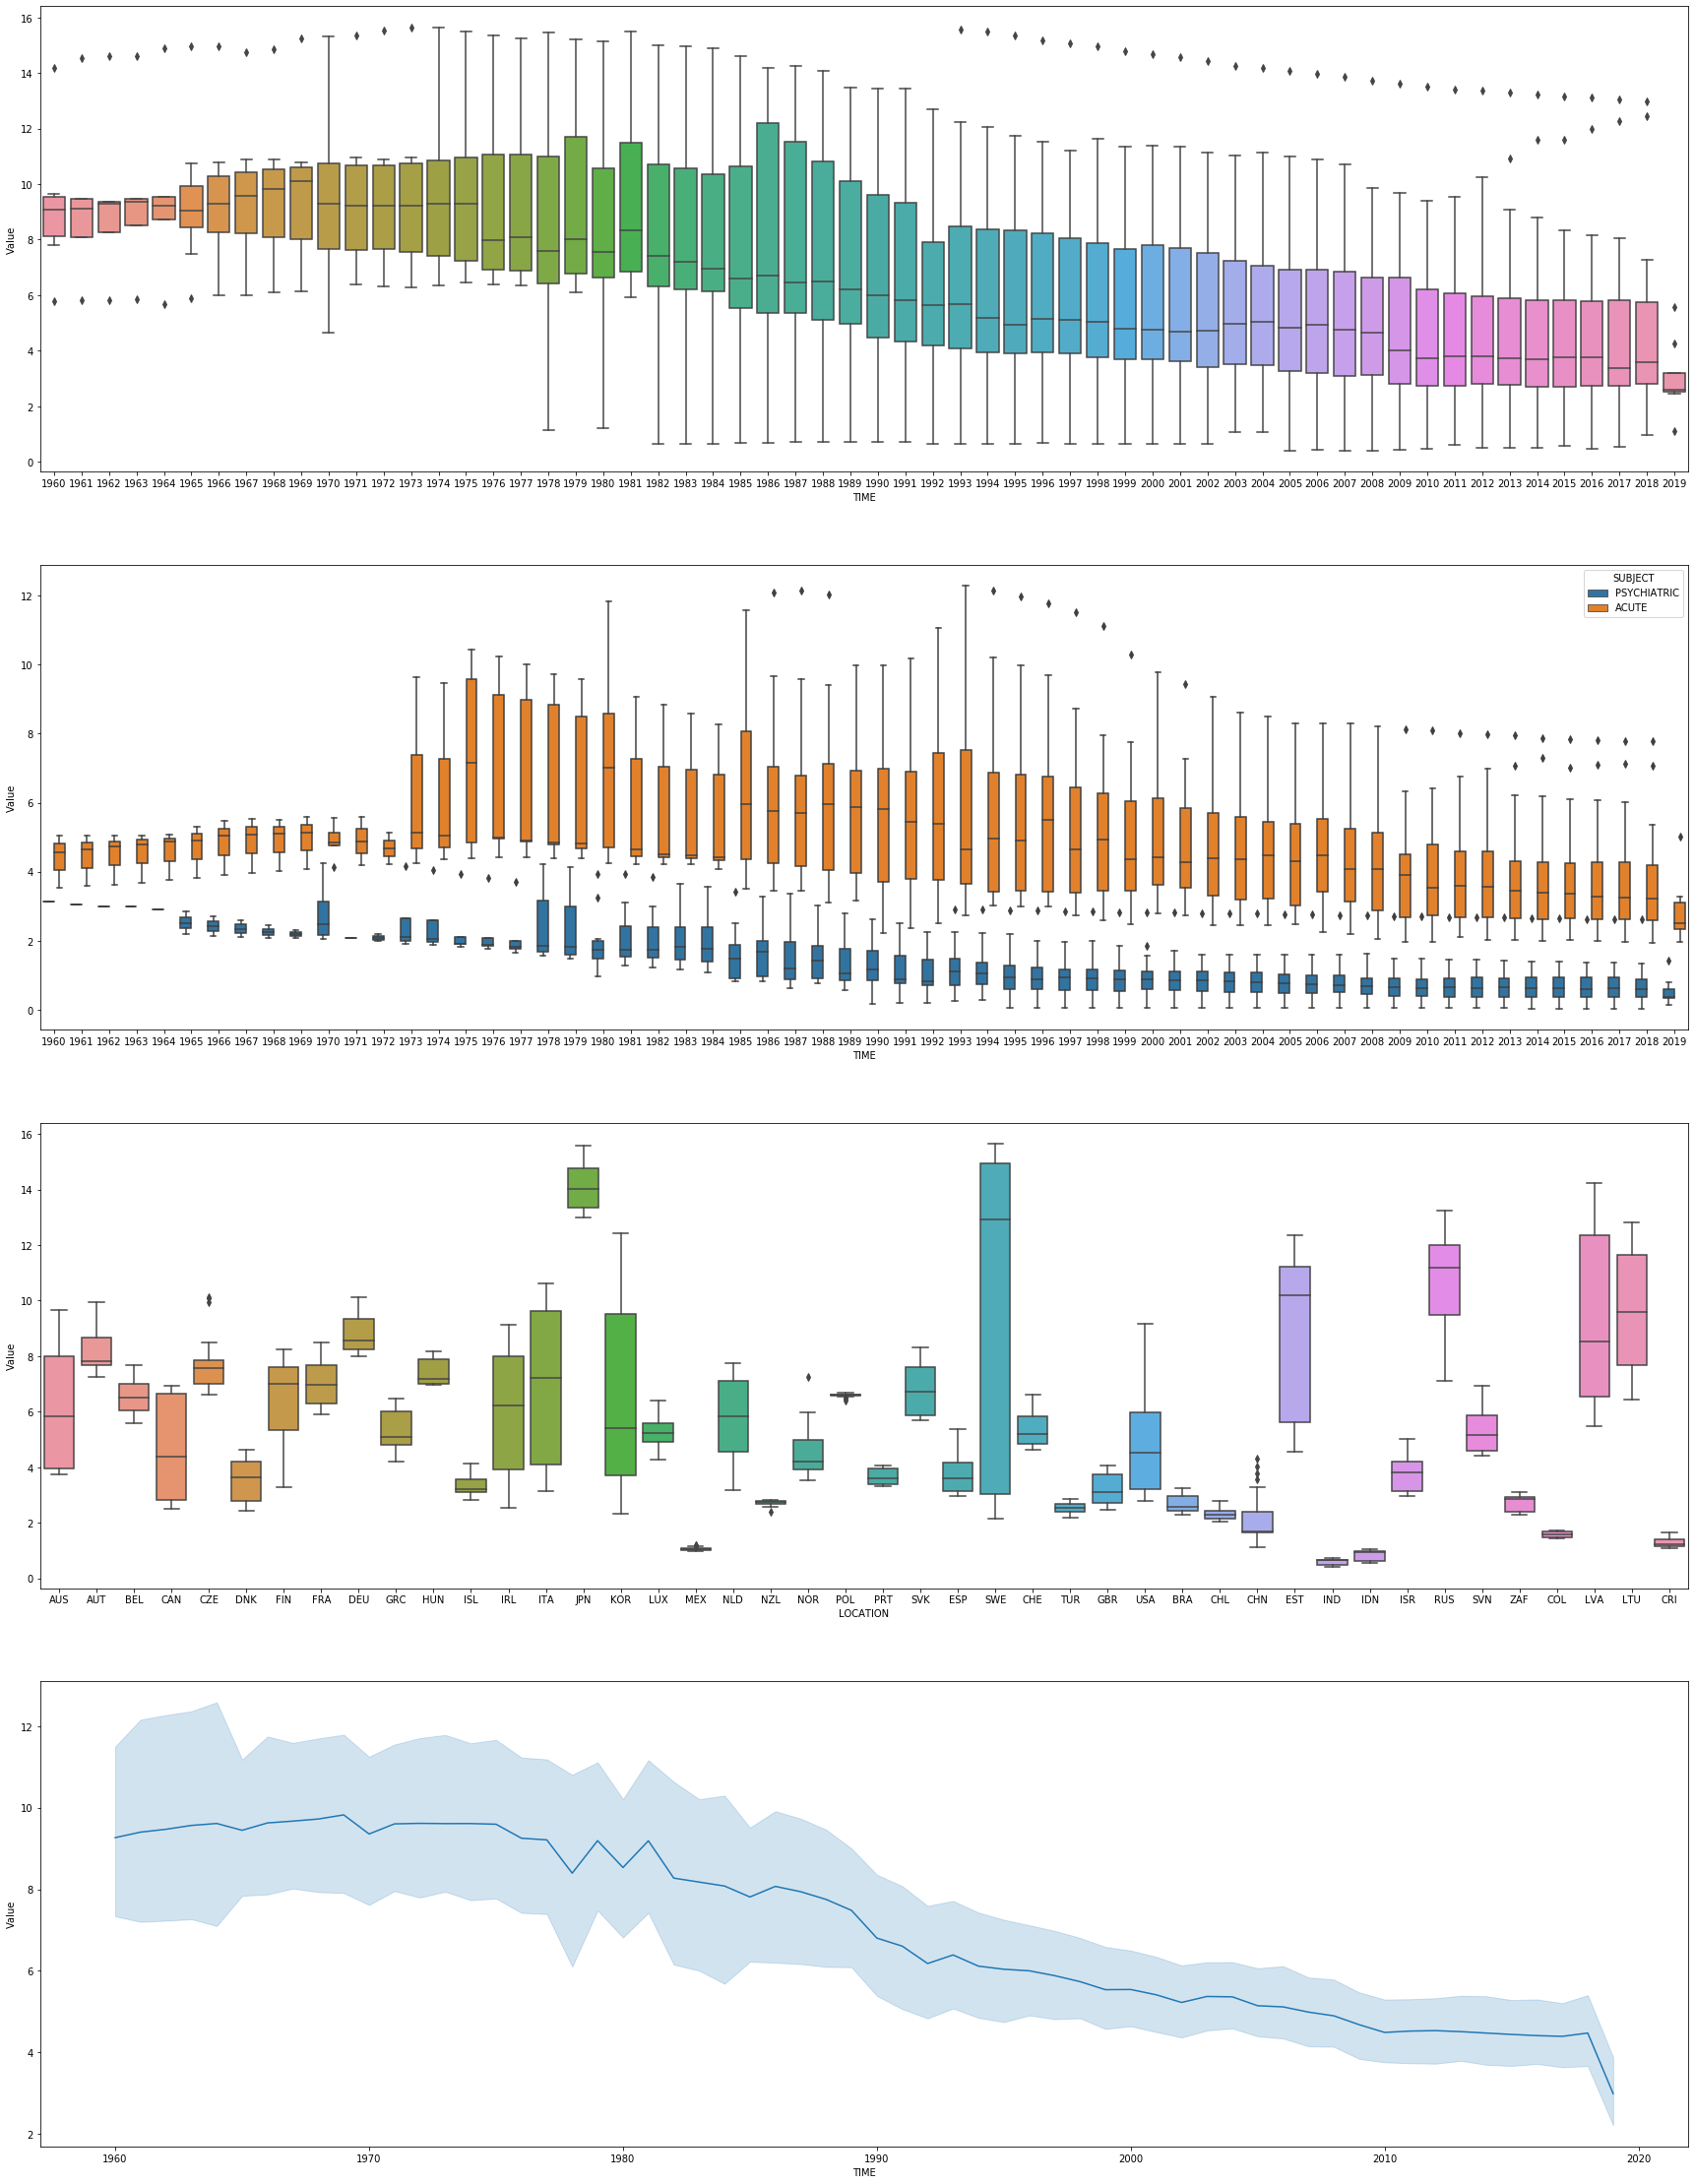

In [32]:
fig = plt.figure(figsize=(30,40))
ax0 = fig.add_subplot(4,1,1)
ax1 = fig.add_subplot(4,1,2)
ax2 = fig.add_subplot(4,1,3)
ax3 = fig.add_subplot(4,1,4)
total_beds = global_beds.loc[(global_beds.SUBJECT=='TOT')].reset_index(drop=True)
beds_sector = global_beds.loc[(global_beds.SUBJECT!='TOT')].reset_index(drop=True)
sns.boxplot(y=total_beds['Value'],x=total_beds['TIME'],data=total_beds,ax=ax0)
sns.boxplot(y=beds_sector['Value'],x=beds_sector['TIME'],hue=beds_sector['SUBJECT'],data=beds_sector,ax=ax1)
sns.boxplot(y=total_beds['Value'],x=total_beds['LOCATION'],data=total_beds,ax=ax2)
sns.lineplot(y=total_beds['Value'],x=total_beds['TIME'],data=total_beds,ax=ax3)

We then find that there is a moderately strong positive relationship between the hospital beds per 1000 population and the time, with strong certainty.

In [33]:
pearson_coef, p_value = stats.pearsonr(total_beds['Value'], total_beds['TIME'])
pearson_coef, p_value

(-0.4722960658282894, 3.6444657724577814e-76)

**We then find the changes in hospital beds per 1000 population, by country.**

With the exception of Korea, Turkey and China, most countries see a decreasing trend in the number of hospital beds per 1000 population.

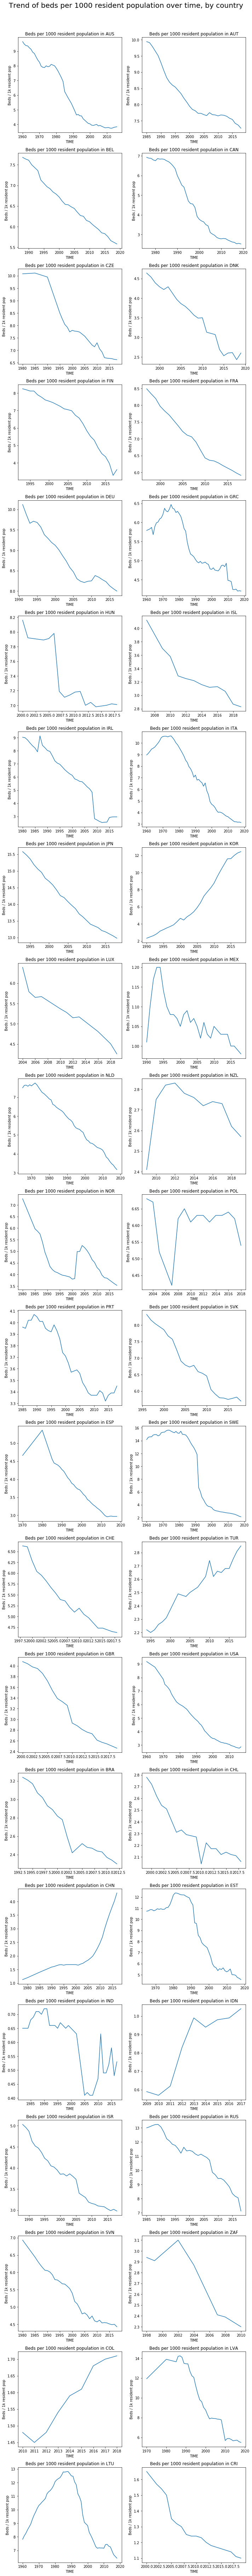

In [34]:
countries = total_beds.LOCATION.unique()
fig, axes = plt.subplots(nrows=int(countries.size/2), ncols=2,  tight_layout=True)

i = 0
for ax, c in zip(axes.ravel(), countries):
    total_beds.loc[total_beds.LOCATION==str(c)].plot(kind='line', y='Value', x='TIME',legend=None, ax=ax,figsize=(10,100))
    ax.set_ylabel('Beds / 1k resident pop')
    ax.set_title('Beds per 1000 resident population in ' + c)
    i = i+1
fig.suptitle('Trend of beds per 1000 resident population over time, by country', fontsize=20,y=1.01)
plt.show()

**We then find the changes in total spendings (by the government and the person) on healthcare, as a percent in GDP.**

Again, we plot four graphs:
1. The total spendings, by year.
2. The total spendings over time, by country.
3. The division of the total spendings, by year.
4. A line graph of the total spendings by year.

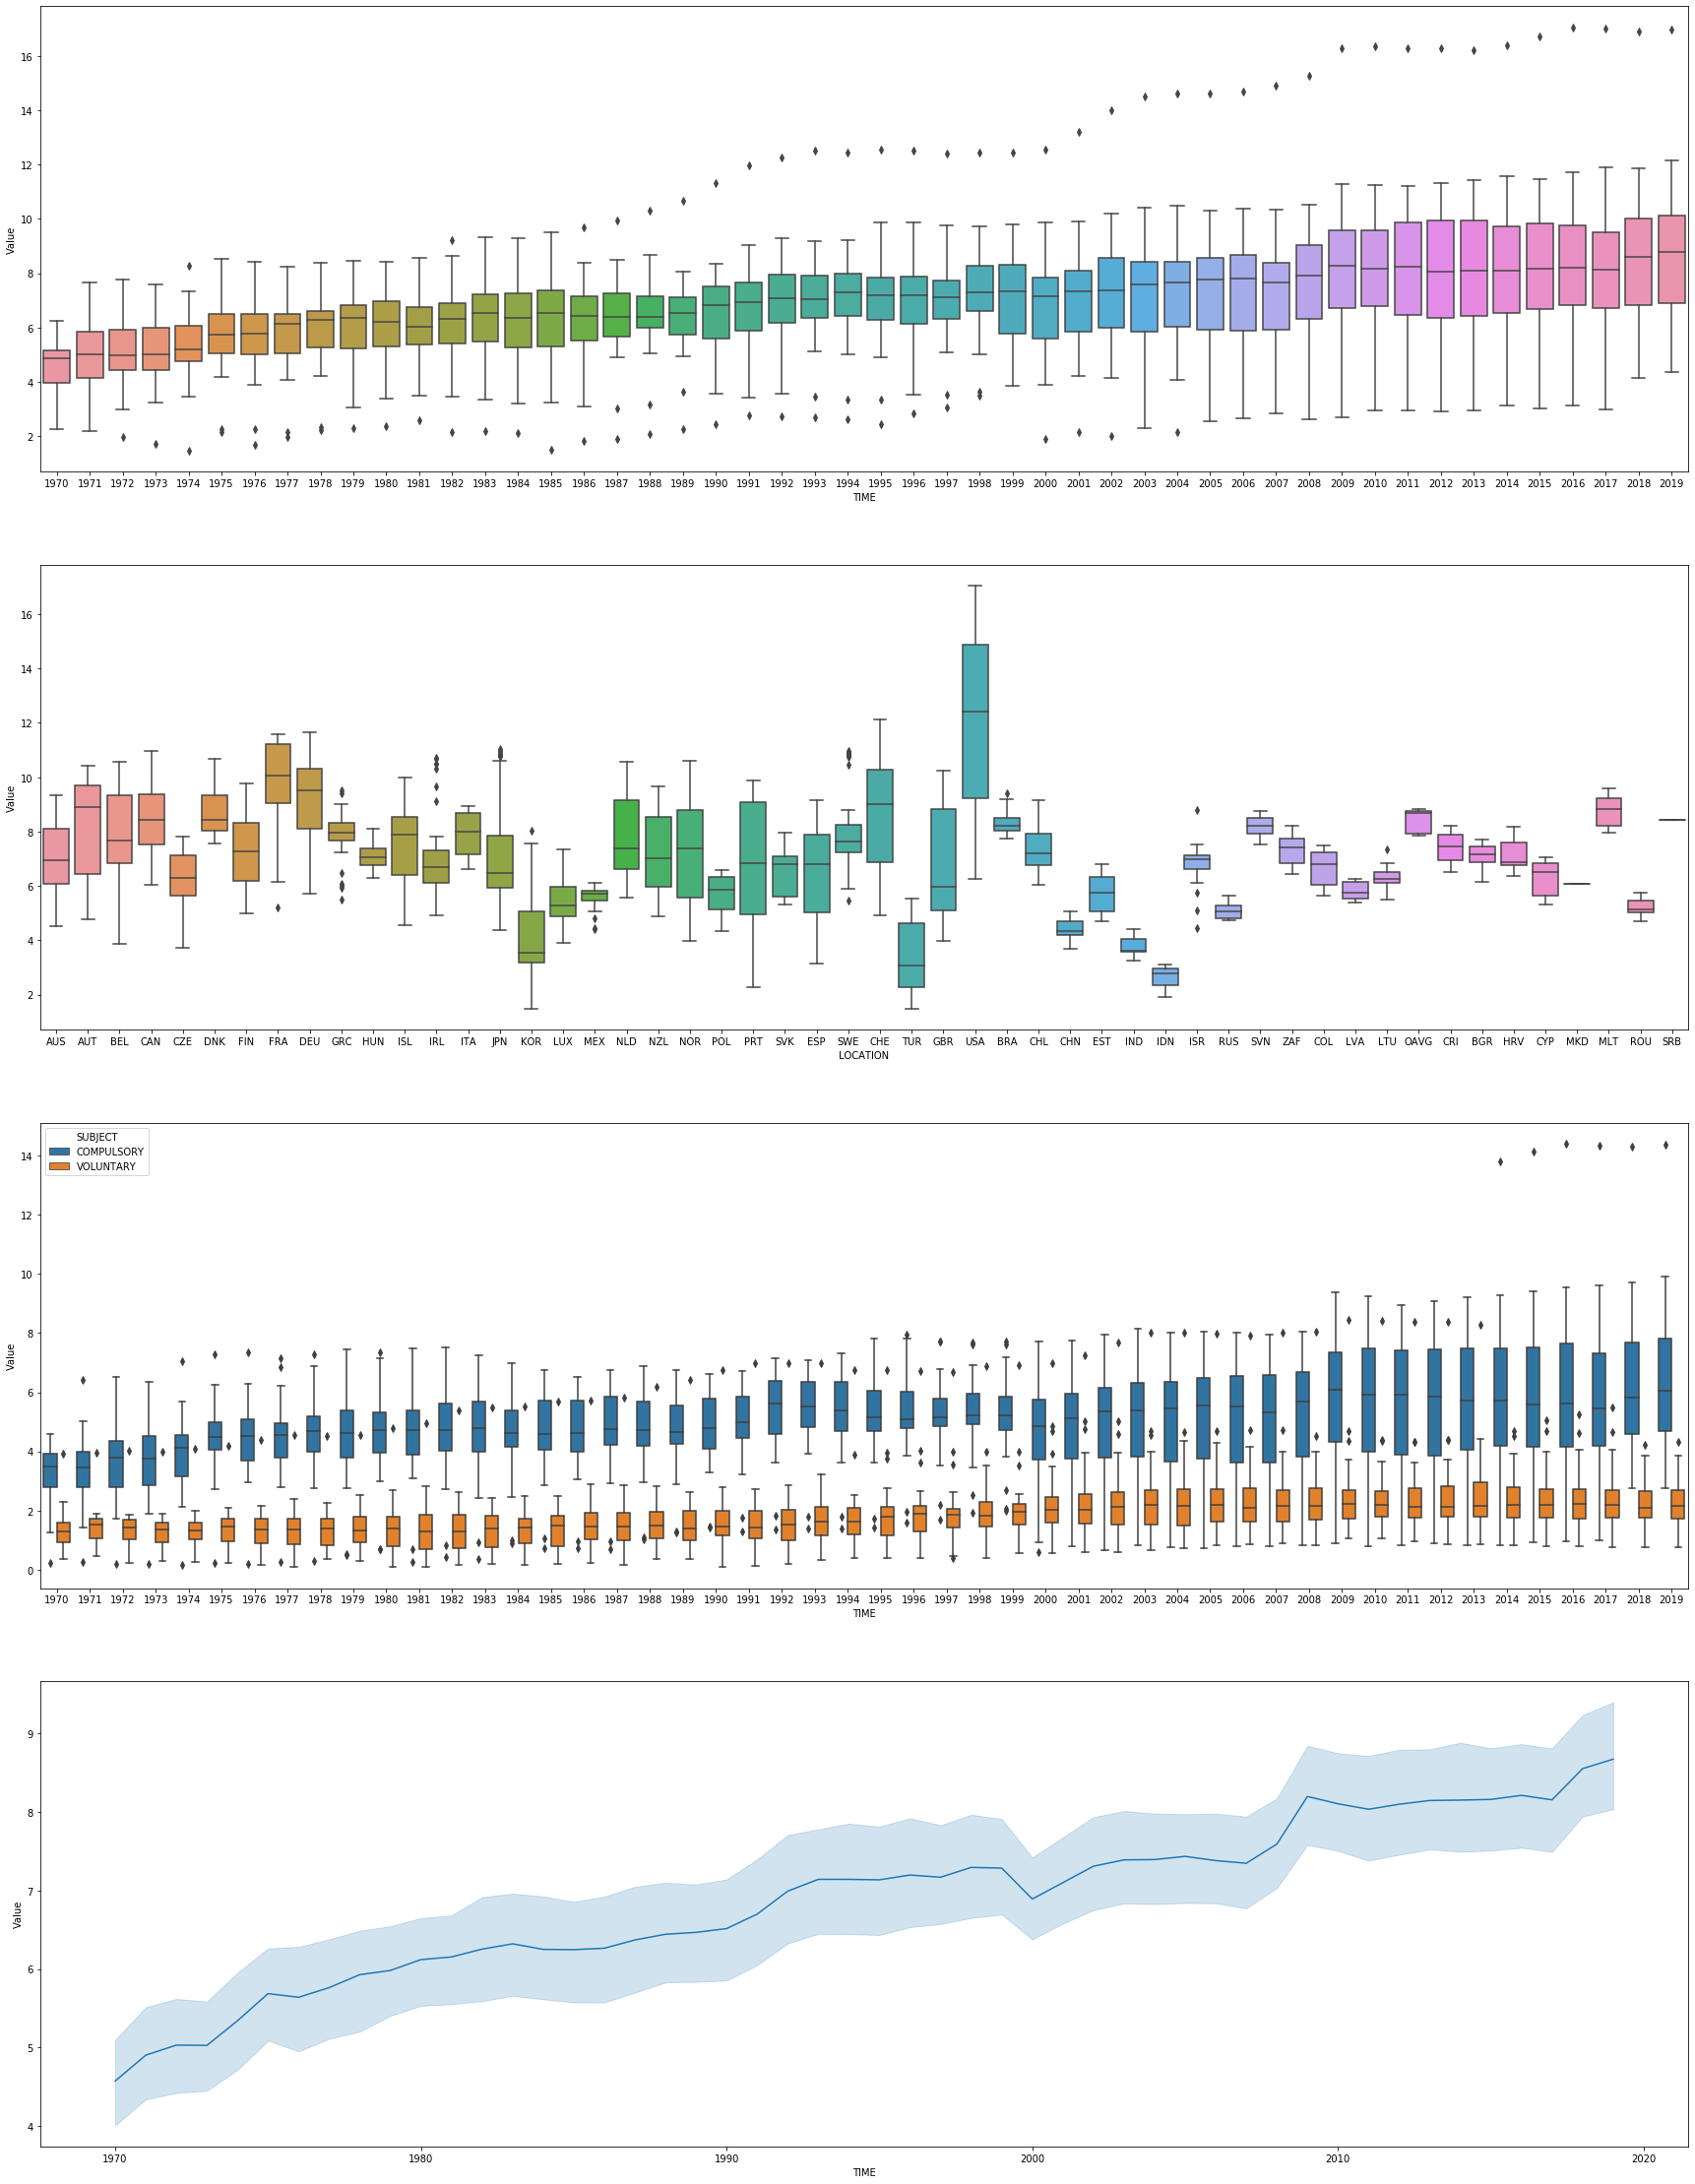

In [35]:
fig = plt.figure(figsize=(30,40))
ax0 = fig.add_subplot(4,1,1)
ax1 = fig.add_subplot(4,1,2)
ax2 = fig.add_subplot(4,1,3)
ax3 = fig.add_subplot(4,1,4)
total_spendings = global_spendings.loc[(global_spendings.MEASURE=='PC_GDP')&(global_spendings.SUBJECT=='TOT')].reset_index(drop=True)
contributions = global_spendings.loc[(global_spendings.SUBJECT!='TOT')&(global_spendings.SUBJECT!='OOPEXP')&(global_spendings.MEASURE=='PC_GDP')].reset_index(drop=True)
sns.boxplot(y=total_spendings['Value'],x=total_spendings['TIME'],data=total_spendings,ax=ax0)
sns.boxplot(y=total_spendings['Value'],x=total_spendings['LOCATION'],data=total_spendings,ax=ax1)
sns.boxplot(y=contributions['Value'],x=contributions['TIME'],hue=contributions['SUBJECT'],data=contributions,ax=ax2)
sns.lineplot(y=total_spendings['Value'],x=total_spendings['TIME'],data=total_spendings,ax=ax3)

**We then find the changes in the total health spendings, by country.**

The strategy is similar to that of plotting the graphs for the total beds per 1000 population.

We found that healthcare costs are generally increasing throughout the world, with the exception of India. 

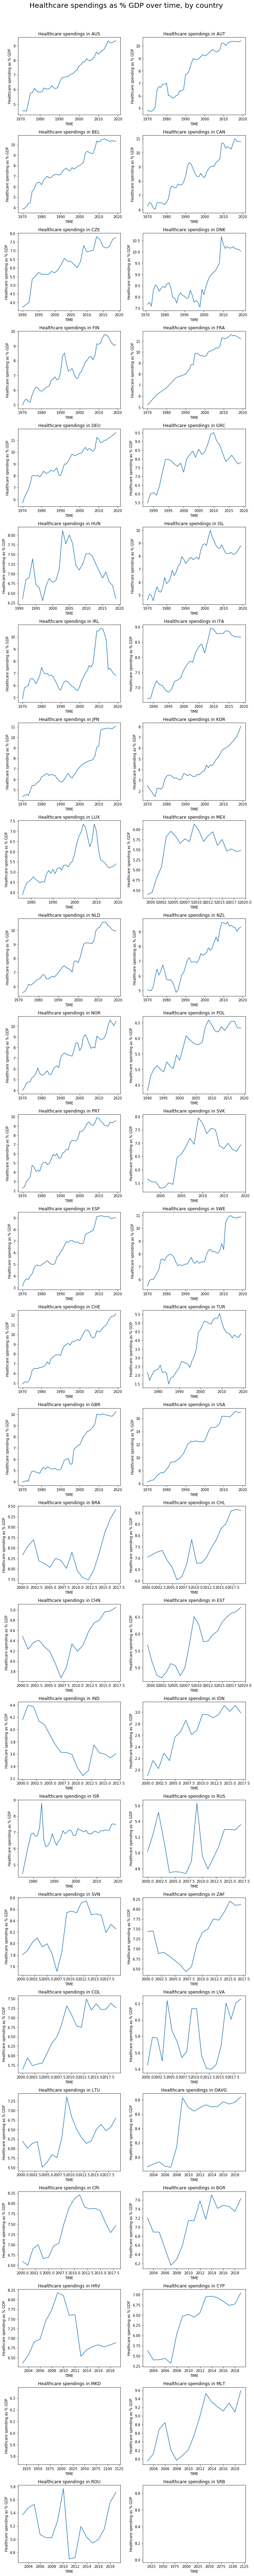

In [36]:
countries = total_spendings.LOCATION.unique()
fig, axes = plt.subplots(nrows=int(countries.size/2), ncols=2,  tight_layout=True)

i = 0
for ax, c in zip(axes.ravel(), countries):
    total_spendings.loc[total_spendings.LOCATION==str(c)].plot(kind='line', y='Value', x='TIME',legend=None, ax=ax,figsize=(10,100))
    ax.set_ylabel('Healthcare spending as % GDP')
    ax.set_title('Healthcare spendings in ' + c)
    i = i+1
fig.suptitle('Healthcare spendings as % GDP over time, by country', fontsize=20,y=1.01)
plt.show()

**Finally, we find the trend in doctors over the years.**

We plot 3 graphs:
1. A boxplot of the doctors per 1000 population in the world, by year.
2. The doctors per 1000 population, by country.
3. A line plot of the doctors per 1000 population by year.

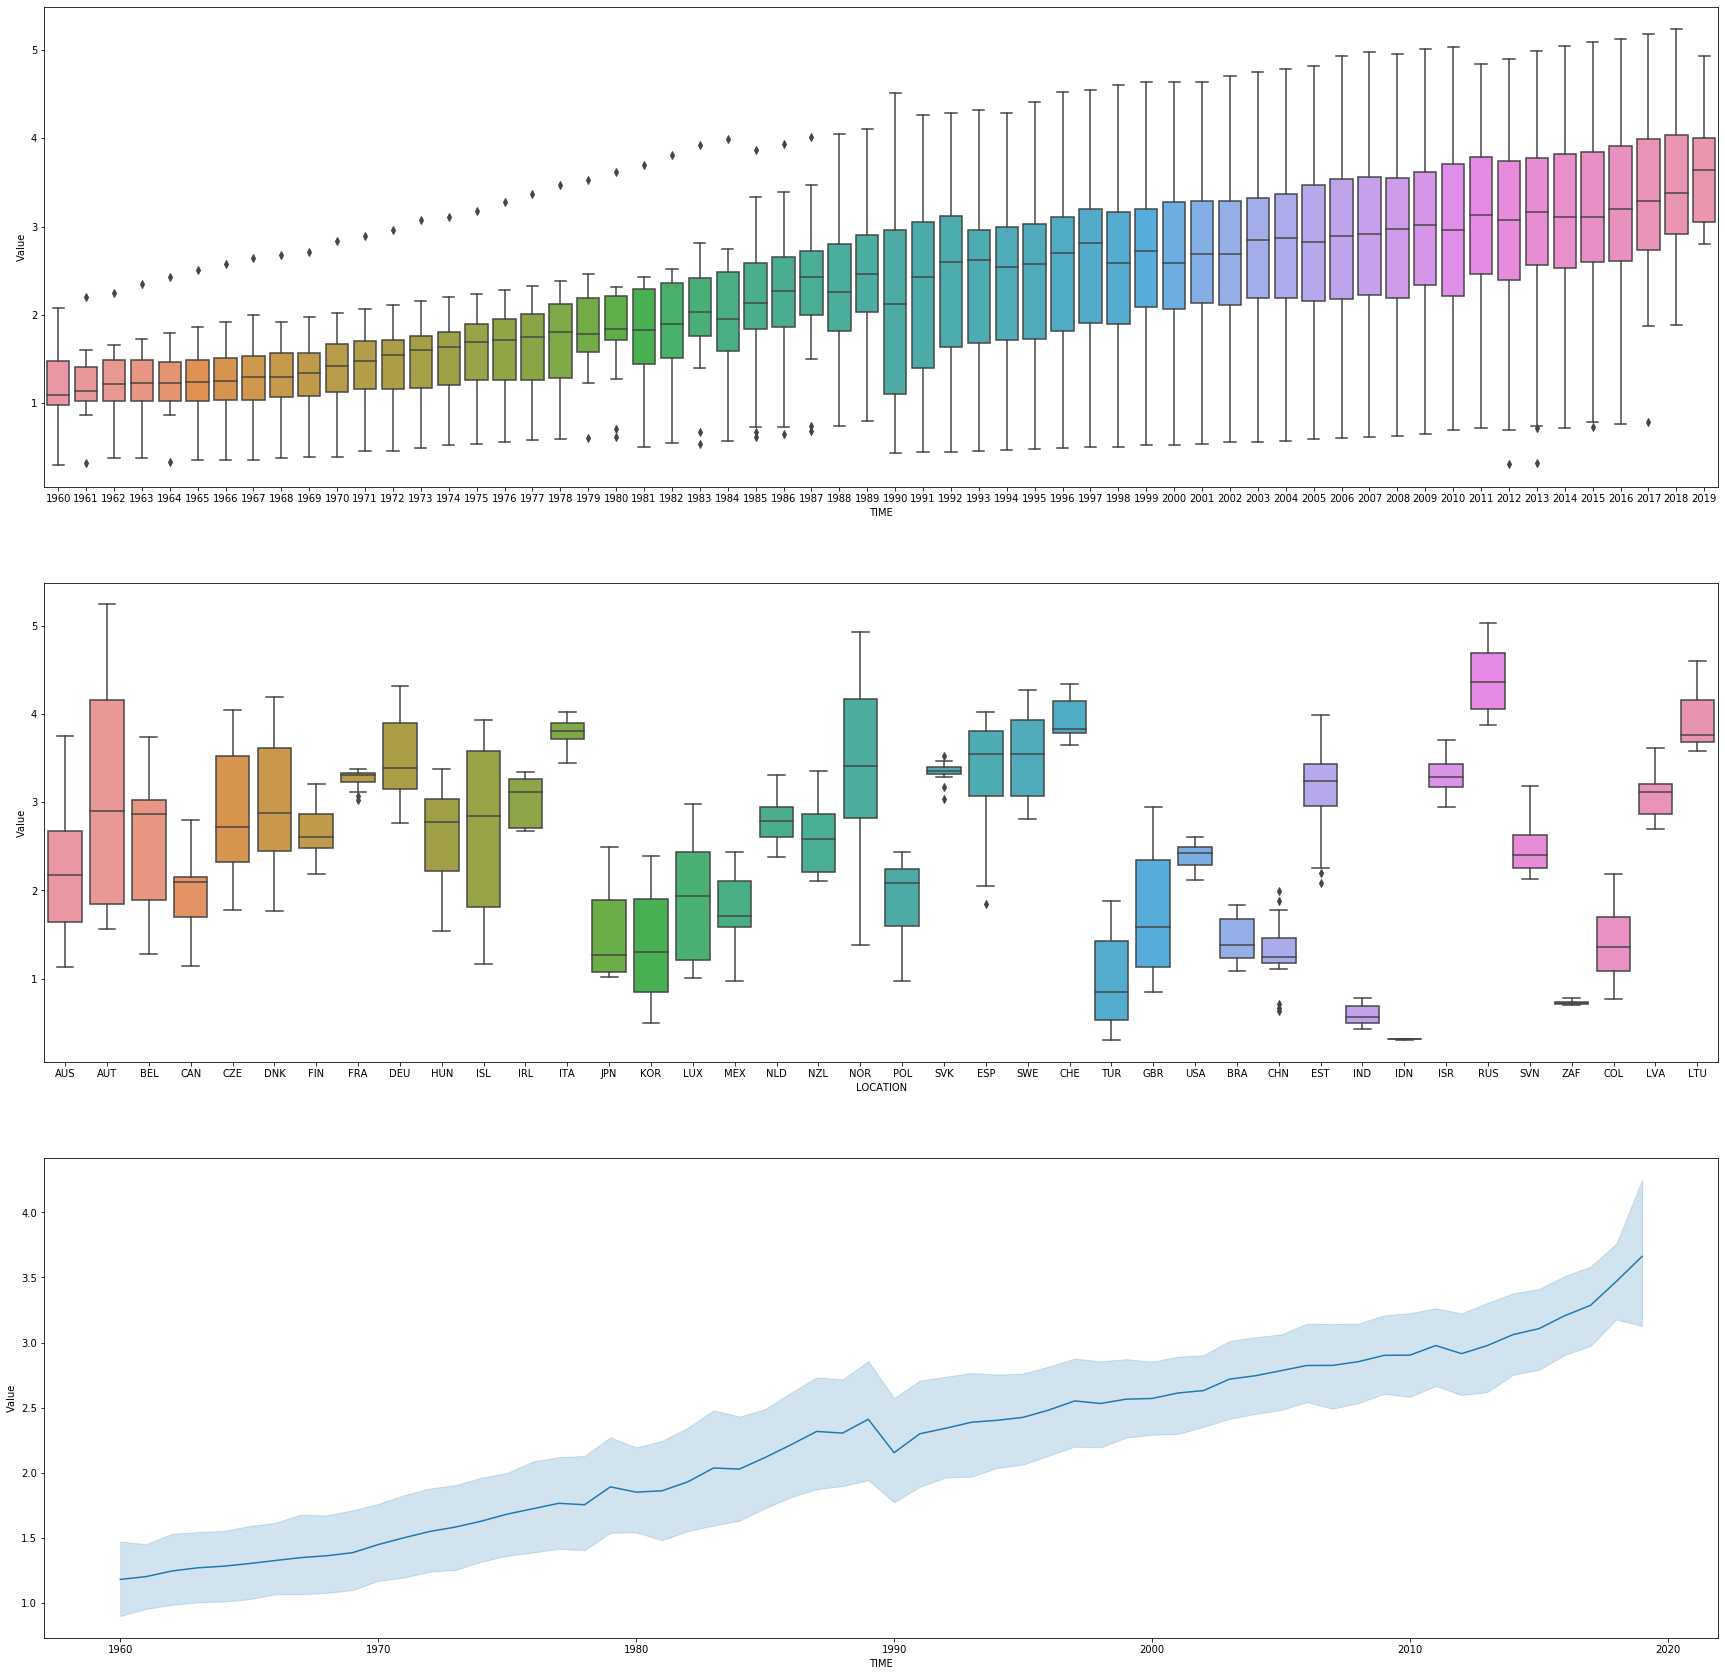

In [37]:
fig = plt.figure(figsize=(30,30))
ax0 = fig.add_subplot(3,1,1)
ax1 = fig.add_subplot(3,1,2)
ax2 = fig.add_subplot(3,1,3)
sns.boxplot(y=global_doctors['Value'],x=global_doctors['TIME'],data=global_doctors,ax=ax0)
sns.boxplot(y=global_doctors['Value'],x=global_doctors['LOCATION'],data=global_doctors,ax=ax1)
sns.lineplot(y=global_doctors['Value'],x=global_doctors['TIME'],data=global_doctors,ax=ax2)

**We also plot the changes in the doctors per 1000 resident population, by country.**

We found that most of the countries see increasing numbers of doctors relative to the population, with Russia and Israel being exceptions to this case. 

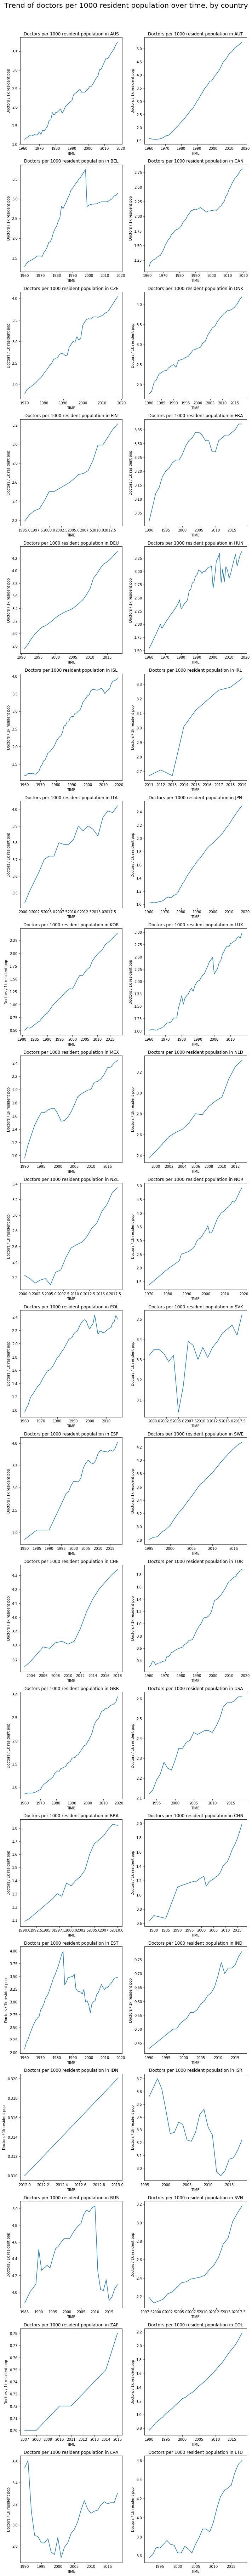

In [38]:
countries = global_doctors.LOCATION.unique()
fig, axes = plt.subplots(nrows=int(countries.size/2), ncols=2,  tight_layout=True)

i = 0
for ax, c in zip(axes.ravel(), countries):
    global_doctors.loc[global_doctors.LOCATION==str(c)].plot(kind='line', y='Value', x='TIME',legend=None, ax=ax,figsize=(10,100))
    ax.set_ylabel('Doctors / 1k resident pop')
    ax.set_title('Doctors per 1000 resident population in ' + c)
    i = i+1
fig.suptitle('Trend of doctors per 1000 resident population over time, by country', fontsize=20,y=1.01)
plt.show()

**Finally, we find the overall score of these healthcare systems.**

We first combine the three dataframes and take the inner value, sacrificing the number of datapoints for the precision of the result. We then "score" the systems by taking the z-score of these columns and adding them. This is favoured over multiplying because the latter will exaggerate the effectiveness of these healthcare systems.

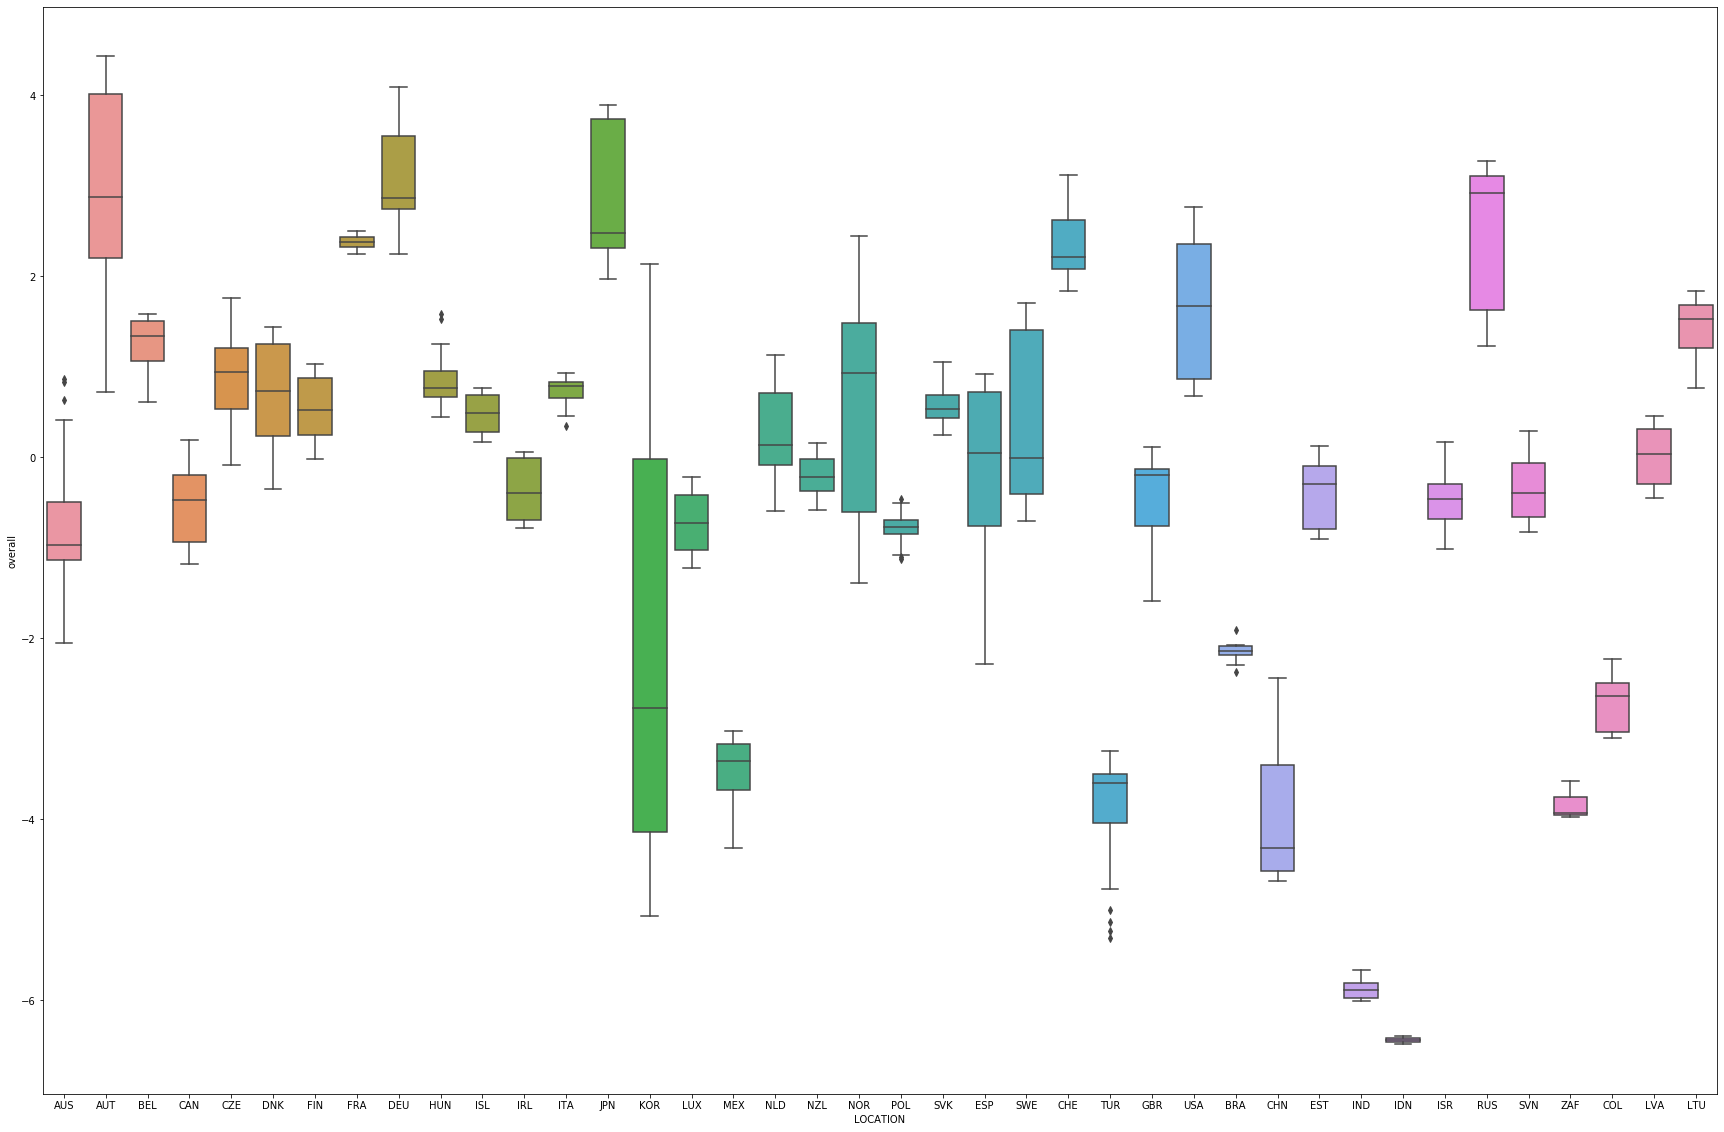

In [39]:
fig = plt.figure(figsize=(30,20))
ax0 = fig.add_subplot(1,1,1)
cols = ['LOCATION','TIME']
combined = total_beds.merge(total_spendings,on=cols,how='inner').merge(global_doctors,on=cols,how='inner')
combined.rename(columns={'Value_x':'beds','Value_y':'spending','Value':'doctors'},inplace=True)
values = ['beds','spending','doctors']
zscore = combined.copy()
zscore[values] = (zscore[values] - zscore[values].mean())/(zscore[values].std())
zscore['overall'] = zscore['beds'] + zscore['doctors'] + zscore['spending']
filtered = zscore[['overall','TIME','LOCATION']]
sns.boxplot(y=filtered['overall'],x=filtered['LOCATION'],data=filtered,ax=ax0)

**And the changes in score by country...**

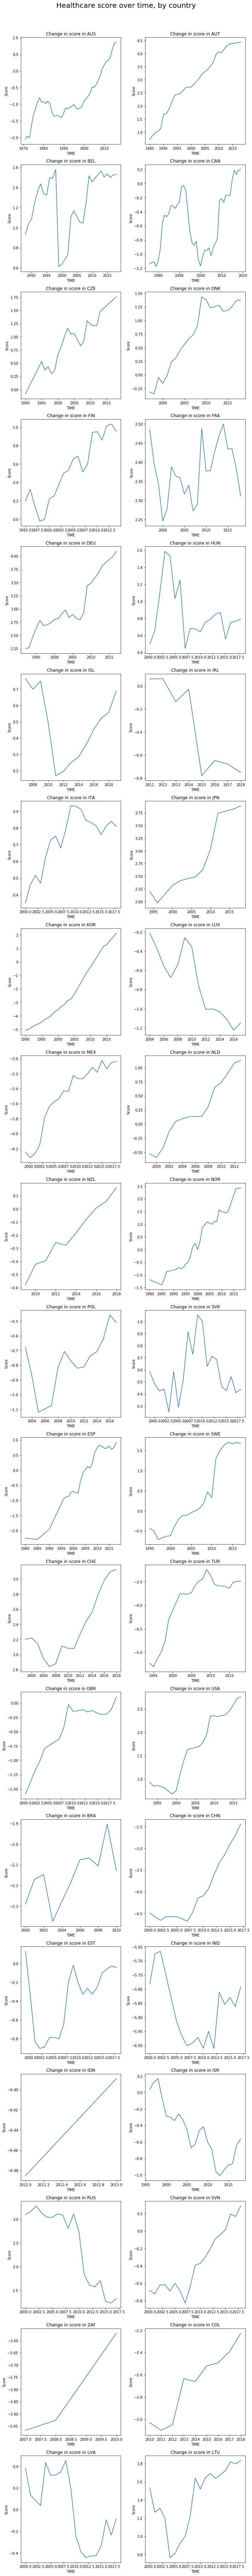

In [40]:
countries = filtered.LOCATION.unique()
fig, axes = plt.subplots(nrows=int(countries.size/2), ncols=2,  tight_layout=True)

i = 0
for ax, c in zip(axes.ravel(), countries):
    filtered.loc[filtered.LOCATION==str(c)].plot(kind='line', y='overall', x='TIME',legend=None, ax=ax,figsize=(10,100))
    ax.set_ylabel('Score')
    ax.set_title('Change in score in ' + c)
    i = i+1
fig.suptitle('Healthcare score over time, by country', fontsize=20,y=1.01)
plt.show()

<a id='results'></a>
## Results

Here, we discuss the results produced from our data analysis. We will look into the outliers and other data points that are unexpected. From this, we will produce our [recommendations and conclusions](#conc)

<a id='rq1'></a>
### Results for [Question 1](#q1)

**We plot a line graph to show the changes in the beds to population ratio by hospital sector.**

Notice how the acute hospitals are seeing the most growth, followed by the community hospitals. Psychiatric hospitals, on the other hand, are seeing some reduction in capacity.

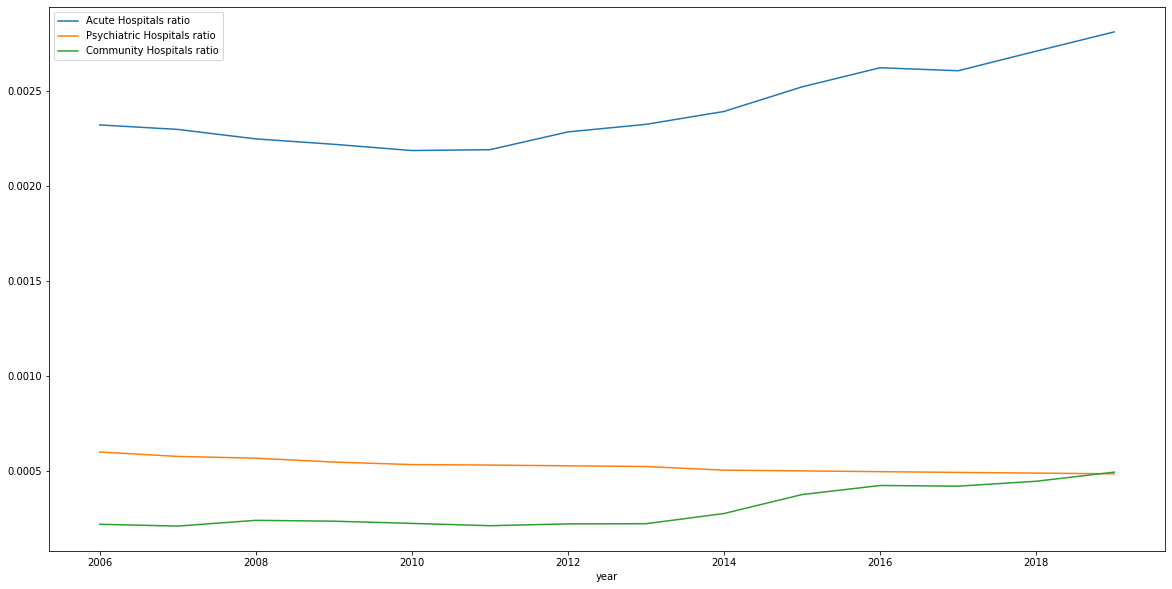

In [41]:
fig = plt.figure(figsize=(20,10))
res1 = fig.add_subplot(1,1,1)
result.plot(x='year',y='Acute Hospitals ratio',ax=res1)
result.plot(x='year',y='Psychiatric Hospitals ratio',ax=res1)
result.plot(x='year',y='Community Hospitals ratio',ax=res1)

**We plot a heatmap to analyse the changes in Singapore's population over time.**

Notice the distictive "waves" on the heatmap as they shift downwards over time. There is a larger, darker wave followed by a smaller, lighter wave.

This can be interpreted as two generations of Singaporeans, the first generation being the 'Gen X' people and greater in population, and the second generation being the millenials. 

From 1990 all the way to 2019, we can see that the population structure of Singaporeans has taken a relatively large turn. There are more elderly and fewer youths among us.

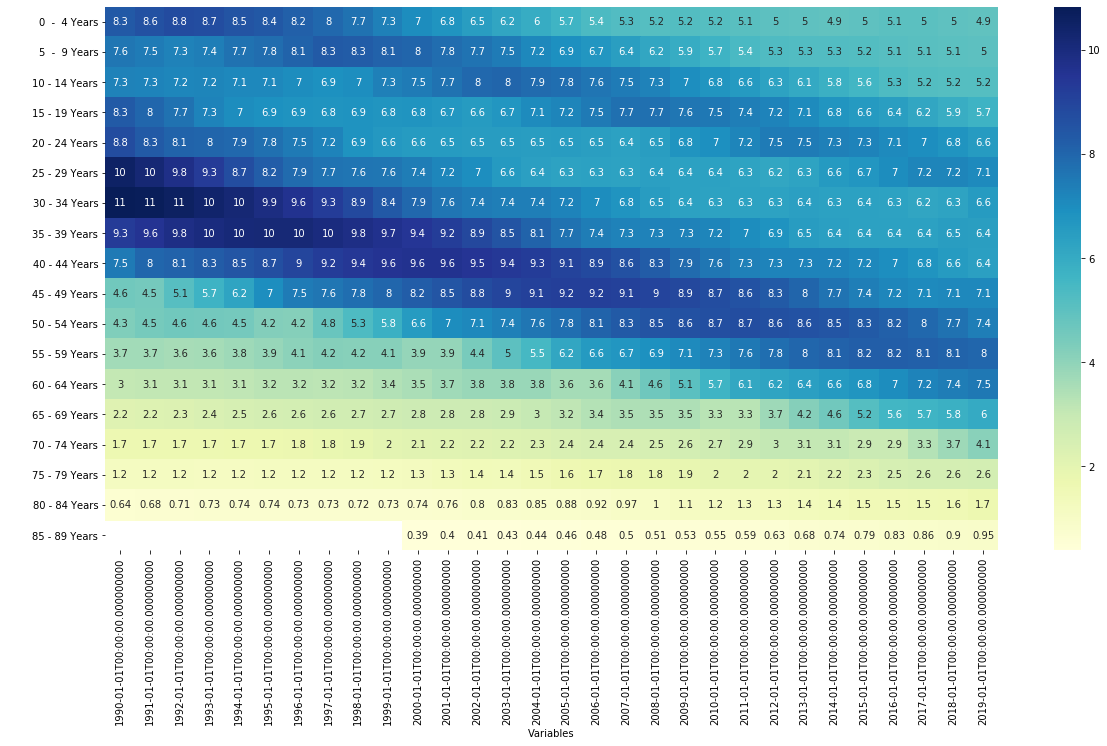

In [42]:
plt.figure(figsize=(20,10))
sns.heatmap(groups.T.iloc[:,2:],cmap='YlGnBu',annot=True)

<a id='rq2'></a>
### Results for [Question 2](#q2)

We will plot the heatmaps of each of the 3 factors individually, followed by another heatmap with the overall score for these healthcare systems.

**We first plot the heatmap of the changes of the total beds by year.**

We can make use of a function to re-organise the data into a new dataframe, which will be used to create the heatmap.

We found that the colour gradually shifts darkens (lower value) over the years, indicating that the beds per unit population is decreasing. The improvement of Korea stands out from this heatmap, as well as the outstanding performance by the Japanese to keep the beds abundant.

Text(0.5, 1, 'Total beds per 1000 people, by year')

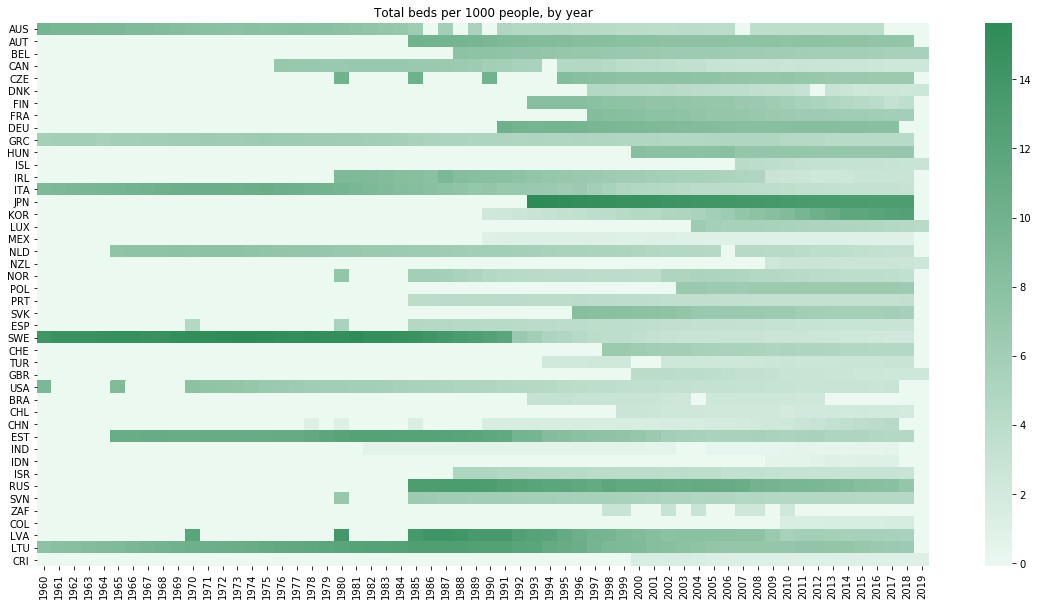

In [43]:
def transfer_temp(row):
    temp.loc[row.TIME,row.LOCATION] = row.Value
    return row

plt.figure(figsize=(20,10))
plot1 = total_beds.iloc[:,[0,-1,-2]]
temp = pd.DataFrame(index=range(plot1.TIME.min(),plot1.TIME.max()),columns=plot1.LOCATION.unique())
plot1 = plot1.apply(transfer_temp,axis='columns')
temp = temp.fillna(plot1.Value.min()-0.5).T
mask = np.zeros_like(temp)
cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(temp,cmap=cmap)
plt.title('Total beds per 1000 people, by year')

**Next, we plot the graph of the healthcare spendings by year.**

We find that the colour 'lightens', indicating that there is increasing healthcare spendings over the years, with the United States going one step further than other countries. Notice too the vertical line from 2009 to 2010, which is likely due to the H1N1 pandemic hitting the world hard.

Text(0.5, 1, 'Total spendings as % GDP, by year')

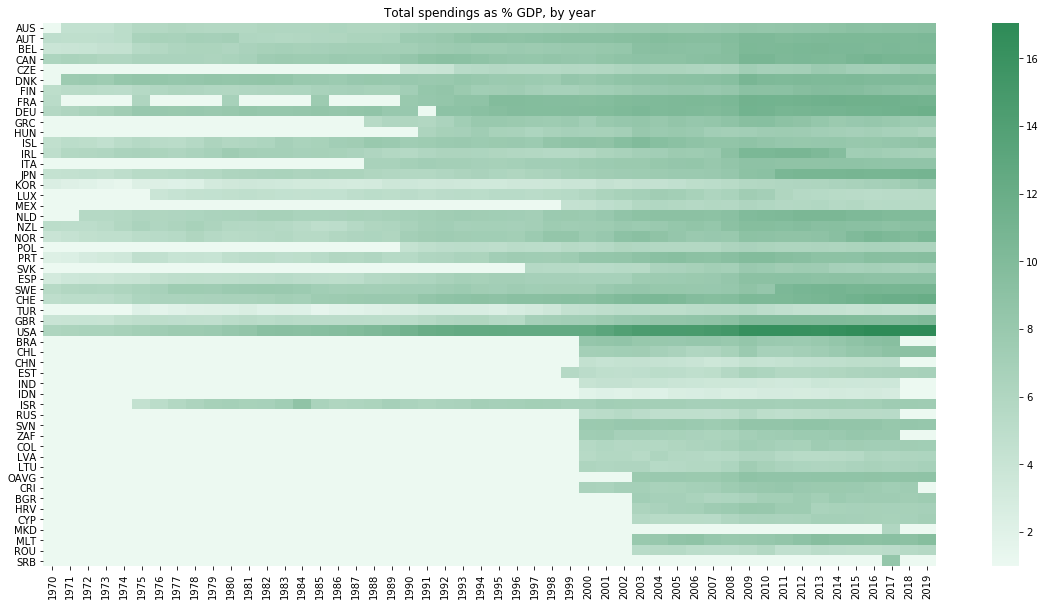

In [44]:
plt.figure(figsize=(20,10))
plot2 = total_spendings.iloc[:,[0,-1,-2]]
temp = pd.DataFrame(index=range(plot2.TIME.min(),plot2.TIME.max()),columns=plot2.LOCATION.unique())
plot2 = plot2.apply(transfer_temp,axis='columns')
temp = temp.fillna(plot2.Value.min()-0.5)
cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(temp.T,cmap=cmap)
plt.title('Total spendings as % GDP, by year')

**Third, the number of doctors worldwide by year.**

Notice how it generally becomes lighter in colour over the years, indicating a relative increase in the doctor population. Also note the drop in the number of doctors for Russia, and the massive improvement of Austria in this aspect from almost 50 years prior.

Text(0.5, 1, 'Doctors per 1000 people, by year')

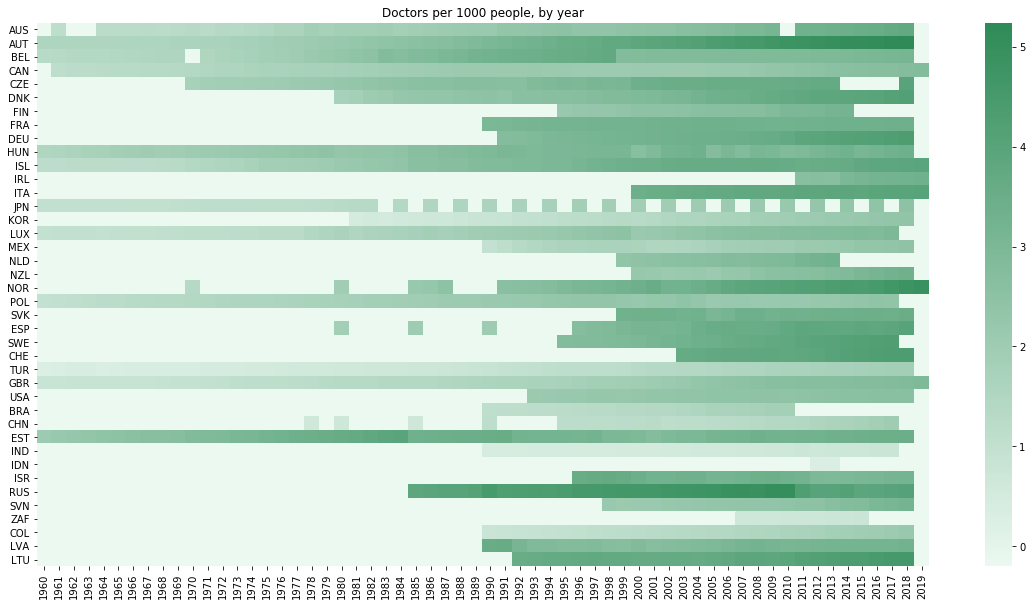

In [45]:
plt.figure(figsize=(20,10))
plot3 = global_doctors.iloc[:,[0,-1,-2]]
temp = pd.DataFrame(index=range(plot3.TIME.min(),plot3.TIME.max()),columns=plot3.LOCATION.unique())
plot3 = plot3.apply(transfer_temp,axis='columns')
temp = temp.fillna(plot3.Value.min()-0.5)
cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(temp.T,cmap=cmap)
plt.title('Doctors per 1000 people, by year')

**Lastly, the heatmap of the overall score by year.**

This heatmap combines all the prior factors. We can once again see the distinct vertical line down the countries at the 2009 to 2010 period, and see a fair number of scores improving, others deproving. A notable improvement overall is Korea and Austria, while the Russian medical system has been seeing declines in our index.

Text(0.5, 1, 'Overall score, by year')

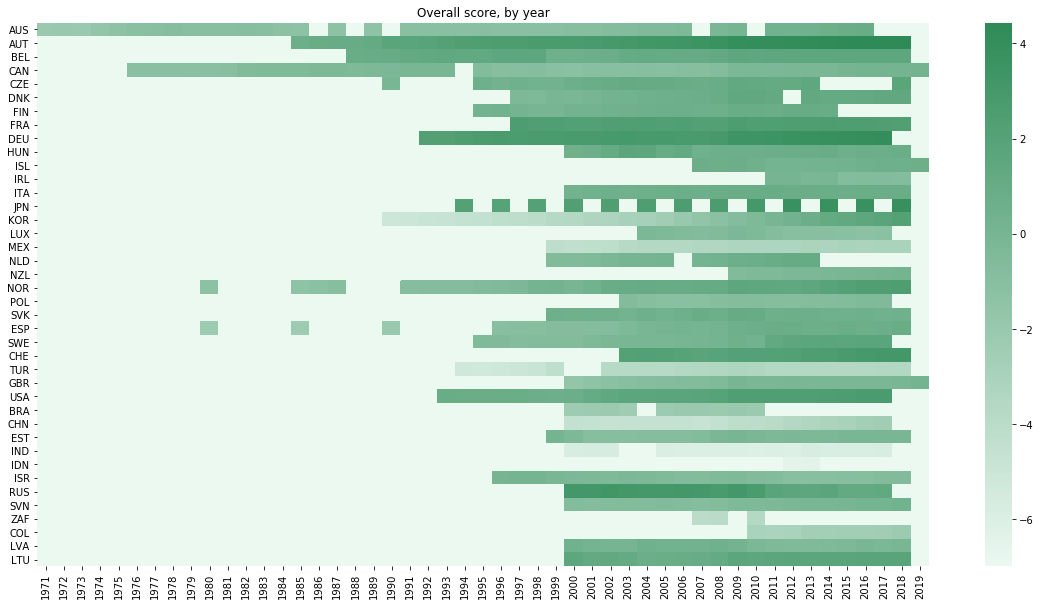

In [46]:
def transfer_overall(row):
    overall.loc[row.TIME,row.LOCATION] = row.overall
    return row

plt.figure(figsize=(20,10))
plot4 = filtered.iloc[:,[0,-1,-2]]
overall = pd.DataFrame(index=range(plot4.TIME.min(),plot4.TIME.max()),columns=plot4.LOCATION.unique())
plot4 = plot4.apply(transfer_overall,axis='columns')
overall = overall.fillna(plot4.overall.min()-0.5)
cmap = sns.light_palette("seagreen", as_cmap=True)
sns.heatmap(overall.T,cmap=cmap)
plt.title('Overall score, by year')

<a id='verify'></a>
## Testing

Ensuring the accuracy of the data is essential in data analysis. I will highlight how the results have been verified, by question. TL;DR the data is verified by cross-checking with other reputable websites and determining whether the findings are similar.

### Verification of Question 1 results
Regarding the population structure, my results align with the well-known issue of Singapore having an ageing population. There are multiple articles by reputable sources touching on this issue and its relevance in Singapore's context.

### Verification of Question 2 results
Regarding the outcome of the healthcare score, it overlaps to a large extent with the top countries in the world in terms of healthcare.

Link: https://ceoworld.biz/2019/08/05/revealed-countries-with-the-best-health-care-systems-2019/

In addtion, implementing an alternative score system, the min-max system, will also yield a similar result:

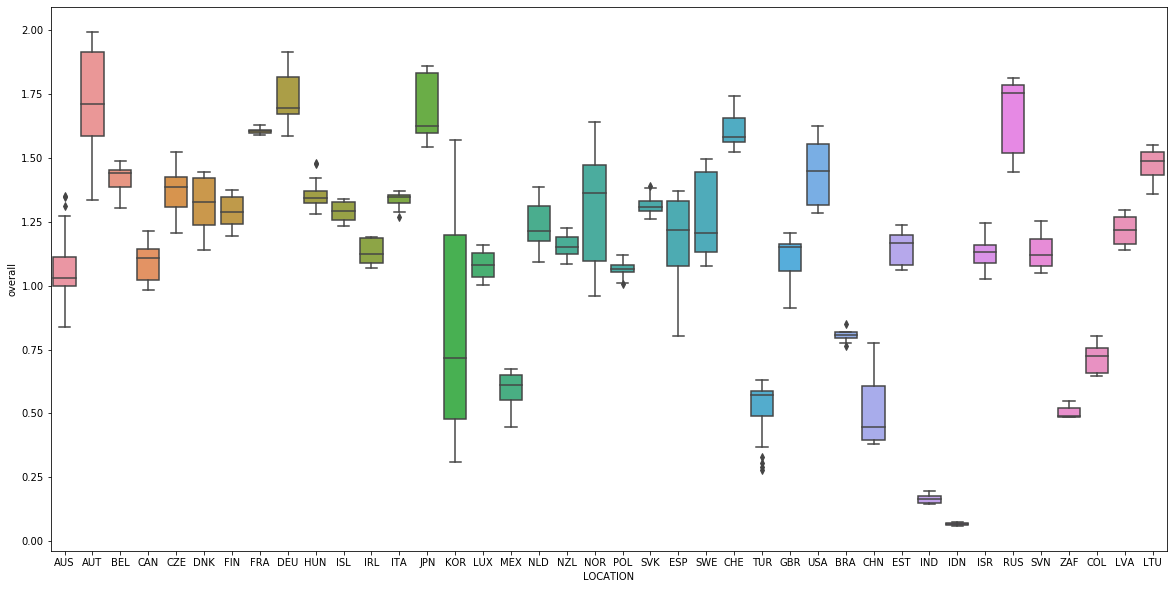

In [47]:
plt.figure(figsize=(20,10))
minmax = combined.copy()
minmax[values] = (minmax[values] - minmax[values].min())/(minmax[values].max()-minmax[values].min())
minmax['overall'] = minmax['beds'] + minmax['doctors'] + minmax['spending']
filtered = minmax[['overall','TIME','LOCATION']]
sns.boxplot(y=filtered['overall'],x=filtered['LOCATION'],data=filtered)

<a id='conc'></a>
## Conclusions and Recommendations

### Question 1
We can clearly see that Singapore's population is ageing quickly, and that the government must invest more of its resources in developing facilities for the elderly like nursing homes, and introduce other policies that help ensure the health of our seniors. This conclusion isn't at all surprising given how much attention Singapore's ageing population has already received.

More startling is that Singapore's psychiatric hospitals are seeing a decline in its capacity over the years; mental health is most definitely an issue in modern-day Singapore, where its citizens suffer from high levels of stress as compared to other countries. The government should also put more of its weight behind supporting psychiatric hospitals as they are an integral part of our holistic health.

### Question 2
We can see that the world is suffering from a two-pronged issue: One is that the number of beds per unit population is decreasing, and the second being that healthcare costs are rising. This will become a big issue in the future as the world's population will eventually begin to age, requiring greater medical expenditure to maintain its health. Reducing beds per unit population is likely due to the problem of overpopulation in the world, and rising healthcare costs is likely because of improper schemes to cushion the financial impact.

However, we can also see that the number of doctors relative to the population is increasing. More doctors means that patients are being tended to more effectively and therefore helps improve the healthcare system in that regard.

I recommend that governments begin programmes to keep overpopulation at bay, especially developing countries that have large birth rates. I also propose for greater international cooperation in healthcare because when there are many countries like Austria, Switzerland and Japan managing their medical sectors well, there are countries that are struggling to cope.

<a id='ref'></a>
## References

### Datasets
1. Hospital Admissions in Singapore. It highlights the admissions of patients in Singapore across government hospitals, divided per sector over the years, per gender and age group.
https://data.gov.sg/dataset/hospital-admissions-and-public-sector-outpatient-attendances-annual?view_id=9d2923d9-4be1-4209-83cc-412e7f3d1f19&resource_id=ba3c89a7-cfc2-4c87-afe3-b688b0f0ad75
2. Number of beds in medical facilities in Singapore. It divides the number of hospital beds in Singapore since 2006 per sector per type of hospital.
https://data.gov.sg/dataset/health-facilities 
4. Singapore’s population over the years. Has data from 1950 on the population size, categorized by age, gender and type (resident, foreigner population) etc.
https://www.singstat.gov.sg/find-data/search-by-theme/population/population-and-population-structure/latest-data 
5. Global data on health spending by country. Includes several metrics like the spending by the population and the government and the percent of gdp used.
https://data.oecd.org/healthres/health-spending.htm
6. Global data on the hospital beds by country. Includes the division by sector.
https://data.oecd.org/healtheqt/hospital-beds.htm
7. Global data on the number of doctors by country per 1000 resident population. 
https://data.oecd.org/healthres/doctors.htm

### Acknowledgments
I would like to thank the Singapore government and the Organisation for Economic Co-operation and Development for publishing their data online and making this project possible. 

In addition, I also thank Mrs Phylliscia Lee for teaching CS4132 Data Analytics and for furthering my interest in the field.